<a href="https://colab.research.google.com/github/Ayatafoy/lstm_stock_market_prediction/blob/master/Stocks_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-profiling==2.9.0

Step 1: Put *handout.zip* to you google drive folder

In [ ]:
!unzip /content/drive/MyDrive/Work/Meson/handout.zip

Archive:  /content/drive/MyDrive/Work/Meson/handout.zip
   creating: data/
  inflating: data/example_predictions.pkl  
  inflating: data/train_features.pkl  
  inflating: data/test_features.pkl  
  inflating: data/train_outcomes.pkl  


In [ ]:
import pandas as pd
import ipywidgets
import sympy
import matplotlib.pyplot as plt
import pickle
import copy
from typing import Optional, Union
import numpy as np
import seaborn as sn
from tqdm import tqdm_notebook as tqdm
from scipy.stats import zscore
from scipy import stats
import seaborn as sns
import pandas_profiling
from missingno import missingno
from statistics import median
from pandas_profiling import ProfileReport
from pandas_profiling.visualisation.utils import hex_to_rgb, plot_360_n0sc0pe
from pandas_profiling.visualisation.missing import missing_matrix, get_font_size
from pandas_profiling.visualisation.context import manage_matplotlib_context
from pandas_profiling.config import config

In [ ]:
def scatter_plot(train_features, x, y, title):
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax1.scatter(train_features[f'f__{x}_1m'], train_features[f'f__{y}_1m'])
    ax2.scatter(train_features[f'f__{x}_3m'], train_features[f'f__{y}_3m'])
    ax3.scatter(train_features[f'f__{x}_6m'], train_features[f'f__{y}_6m'])
    ax4.scatter(train_features[f'f__{x}_12m'], train_features[f'f__{y}_12m'])
    ax1.set_title(f'{title} 1 M')
    ax1.set_xlabel('Buy')
    ax1.set_ylabel('Sell')

    ax2.set_title(f'{title} 3 M')
    ax2.set_xlabel('Buy')
    ax2.set_ylabel('Sell')

    ax3.set_title(f'{title} 6 M')
    ax3.set_xlabel('Buy')
    ax3.set_ylabel('Sell')

    ax4.set_title(f'{title} 12 M')
    ax4.set_xlabel('Buy')
    ax4.set_ylabel('Sell')

In [ ]:
def distribution_plot(train_features, x, title):
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    data_1m = train_features[f'f__{x}_1m']
    data_3m = train_features[f'f__{x}_3m']
    data_6m = train_features[f'f__{x}_6m']
    data_12m = train_features[f'f__{x}_12m']
    ax1.hist(
        data_1m,
        bins=50, 
        range=(data_1m.min(), data_1m.max()),
        density=False,
        cumulative=False
    )
    ax2.hist(
        data_3m,
        bins=50, 
        range=(data_3m.min(), data_3m.max()),
        density=False,
        cumulative=False
    )
    ax3.hist(
        data_6m,
        bins=50, 
        range=(data_6m.min(), data_6m.max()),
        density=False,
        cumulative=False
    )
    ax4.hist(
        data_12m,
        bins=50, 
        range=(data_12m.min(), data_12m.max()),
        density=False,
        cumulative=False
    )
    ax1.set_title(f'{title} 1 M')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')

    ax2.set_title(f'{title} 3 M')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')

    ax3.set_title(f'{title} 6 M')
    ax3.set_xlabel('Value')
    ax3.set_ylabel('Frequency')

    ax4.set_title(f'{title} 12 M')
    ax4.set_xlabel('Value')
    ax4.set_ylabel('Frequency')

In [ ]:
def drop_outliers(data, feature_name, threshold=1.5):
    data_preproc = data[[feature_name]]
    
    Q1 = data_preproc.quantile(0.01)
    Q3 = data_preproc.quantile(0.99)
    IQR = Q3 - Q1

    data_outliers = data_preproc[((data_preproc < (Q1 - threshold * IQR)) | (data_preproc > (Q3 + threshold * IQR))).any(axis=1)]
    data.loc[data_outliers.index] = median(data[feature_name])

    return data

In [ ]:
train_features = pd.read_pickle('data/train_features.pkl')
train_outcomes = pd.read_pickle('data/train_outcomes.pkl')
train_features = train_features.join(train_outcomes)
train_features = train_features.drop_duplicates()

In [ ]:
train_features.head()

f__buytransactions_1m  ...  g__12m_binary
date       tradingitemid                         ...               
2004-08-06 2585893                          1.0  ...              0
           2585895                          2.0  ...              1
           2585941                          0.0  ...              1
           2585957                          0.0  ...              1
           2586016                          0.0  ...              0

[5 rows x 33 columns]

In [ ]:
train_features.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,f__buytransactions_1m,f__selltransactions_1m,f__buyshares_1m,f__sellshares_1m,f__buysharespctsharesout_1m,f__sellsharespctsharesout_1m,f__uniquebuyers_1m,f__uniquesellers_1m,f__buytransactions_3m,f__selltransactions_3m,f__buyshares_3m,f__sellshares_3m,f__buysharespctsharesout_3m,f__sellsharespctsharesout_3m,f__uniquebuyers_3m,f__uniquesellers_3m,f__buytransactions_6m,f__selltransactions_6m,f__buyshares_6m,f__sellshares_6m,f__buysharespctsharesout_6m,f__sellsharespctsharesout_6m,f__uniquebuyers_6m,f__uniquesellers_6m,f__buytransactions_12m,f__selltransactions_12m,f__buyshares_12m,f__sellshares_12m,f__buysharespctsharesout_12m,f__sellsharespctsharesout_12m,f__uniquebuyers_12m,f__uniquesellers_12m,g__12m_binary
count,1290850.000000,1290850.000000,683932.000000,662147.000000,683932.000000,662147.000000,1290850.000000,1290850.000000,1290850.000000,1290850.000000,1086329.000000,981608.000000,1086329.000000,981608.000000,1290850.000000,1290850.000000,1290850.000000,1290850.000000,1228830.000000,1125455.000000,1228830.000000,1125455.000000,1290850.000000,1290850.000000,1290850.000000,1290850.000000,1279176.000000,1206185.000000,1279176.000000,1206185.000000,1290850.000000,1290850.000000,1290850.000000
mean,3.520042,2.332651,5415779924.069901,-582537.331111,20.417096,-0.477286,2.541875,1.521205,9.899004,6.504207,9092514599.700039,-1096367.832154,36.849809,-0.334274,5.926116,3.287927,19.292048,12.647418,18085497899.961079,-1854180.094627,61.750124,-0.303223,9.090464,5.023289,36.882976,24.014391,36677475267.576393,-3309114.047276,105.514664,-0.311567,13.252517,7.040728,0.525604
std,7.033930,4.993036,2585642802508.951660,15908361.348875,7291.654281,232.951255,4.029849,2.396384,14.277754,11.162673,3350255320465.124512,22002273.358094,9756.424194,191.336455,5.576814,3.488317,24.029188,19.031579,4725005773321.026367,28432817.262486,12612.419618,178.691914,6.152801,4.239668,40.442007,31.320252,6728765036720.788086,39061272.622796,16371.771391,172.650611,6.135879,4.939232,0.499344
min,0.000000,0.000000,0.010000,-2553370370.000000,0.000000,-131721.310000,0.000000,0.000000,0.000000,0.000000,0.010000,-2555656960.000000,0.000000,-131721.310000,0.000000,0.000000,0.000000,0.000000,0.010000,-2558991360.000000,0.000000,-131721.310000,0.000000,0.000000,0.000000,0.000000,0.010000,-3419928320.000000,0.000000,-131721.310000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4016.075000,-110100.000000,0.000065,-0.001754,0.000000,0.000000,1.000000,1.000000,13888.000000,-252223.000000,0.000263,-0.004090,1.000000,1.000000,6.000000,2.000000,48746.200000,-500000.000000,0.001050,-0.008358,4.000000,2.000000,15.000000,6.000000,184951.000000,-1067792.000000,0.003745,-0.017880,9.000000,3.000000,0.000000
50%,1.000000,1.000000,23355.405000,-29000.000000,0.000472,-0.000471,1.000000,1.000000,6.000000,3.000000,69444.000000,-67441.500000,0.001480,-0.001128,5.000000,2.000000,13.000000,8.000000,190464.000000,-140984.000000,0.003897,-0.002402,8.000000,4.000000,26.000000,16.000000,482203.000000,-317738.250000,0.009021,-0.005546,13.000000,7.000000,1.000000
75%,4.000000,3.000000,121016.000000,-6864.500000,0.002591,-0.000109,4.000000,2.000000,13.000000,9.000000,286005.000000,-15438.000000,0.005715,-0.000277,9.000000,5.000000,25.000000,17.000000,579210.500000,-34039.000000,0.010900,-0.000652,13.000000,8.000000,45.000000,33.000000,1164297.200000,-83100.000000,0.021463,-0.001651,17.000000,10.000000,1.000000
max,399.000000,363.000000,1234567950000000.000000,-0.010000,2954768.000000,0.000000,43.000000,35.000000,1066.000000,986.000000,1234567950000000.000000,-0.010000,2954768.000000,0.000000,50.000000,36.000000,1356.000000,1270.000000,1234567950000000.000000,-0.010000,3120768.000000,0.000000,52.000000,41.000000,2038.000000,1778.000000,1234567950000000.000000,-0.010000,3120768.000000,0.000000,53.000000,46.000000,1.000000


#Historical data analisys

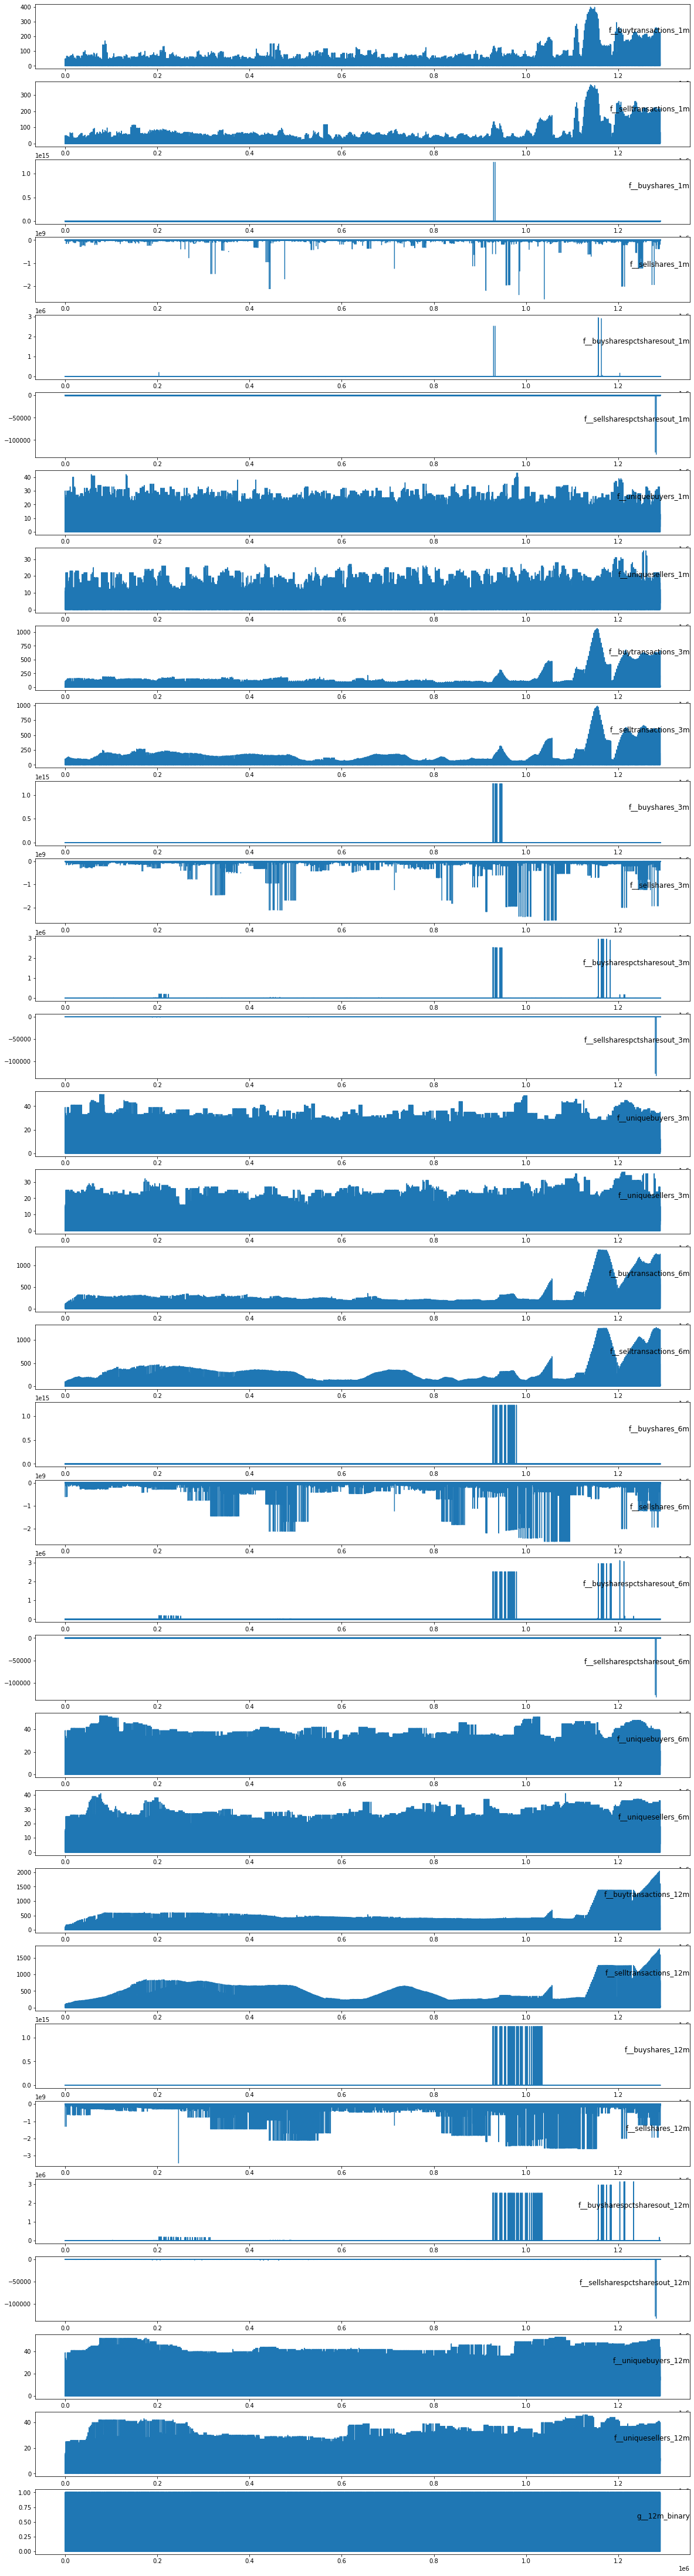

In [ ]:
values = train_features.values
columns = list(range(len(train_features.columns)))
i = 1
plt.figure(figsize=(20, 80))
for column in columns:
    plt.subplot(len(columns), 1, i)
    plt.plot(values[:, column])
    plt.title(train_features.columns[column], y=0.5, loc='right')
    i += 1
plt.show()

#Buy / Sell transactions outliers treatment

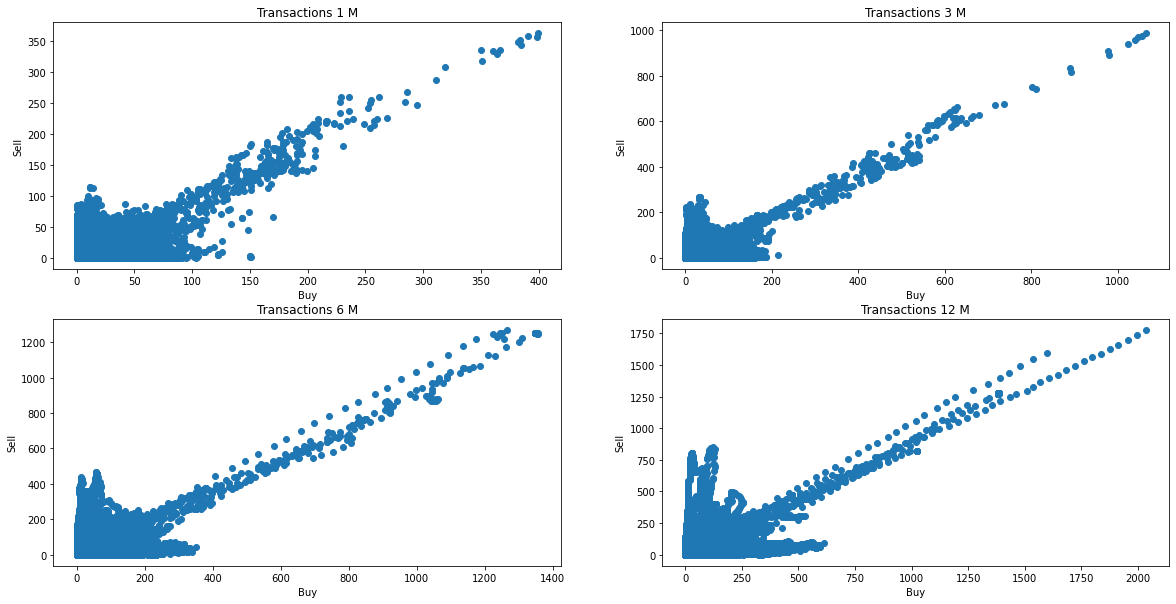

In [ ]:
scatter_plot(train_features, 'buytransactions', 'selltransactions', 'Transactions')

In [ ]:
train_features = drop_outliers(train_features, 'f__buytransactions_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buytransactions_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buytransactions_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buytransactions_12m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__selltransactions_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__selltransactions_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__selltransactions_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__selltransactions_12m', threshold=1.5)

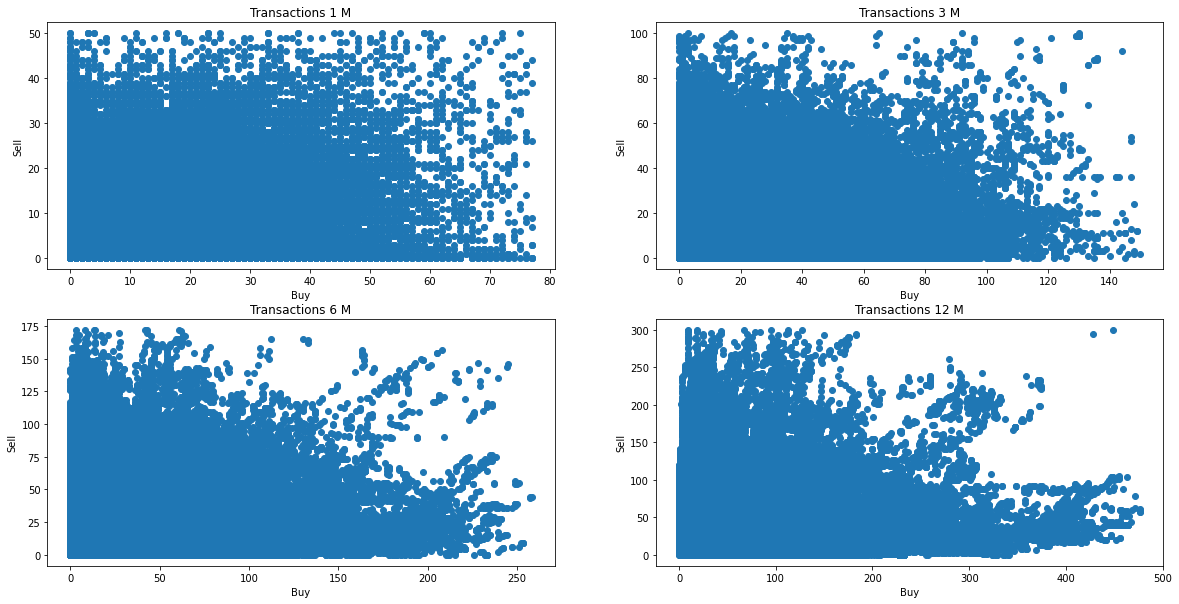

In [ ]:
scatter_plot(train_features, 'buytransactions', 'selltransactions', 'Transactions')

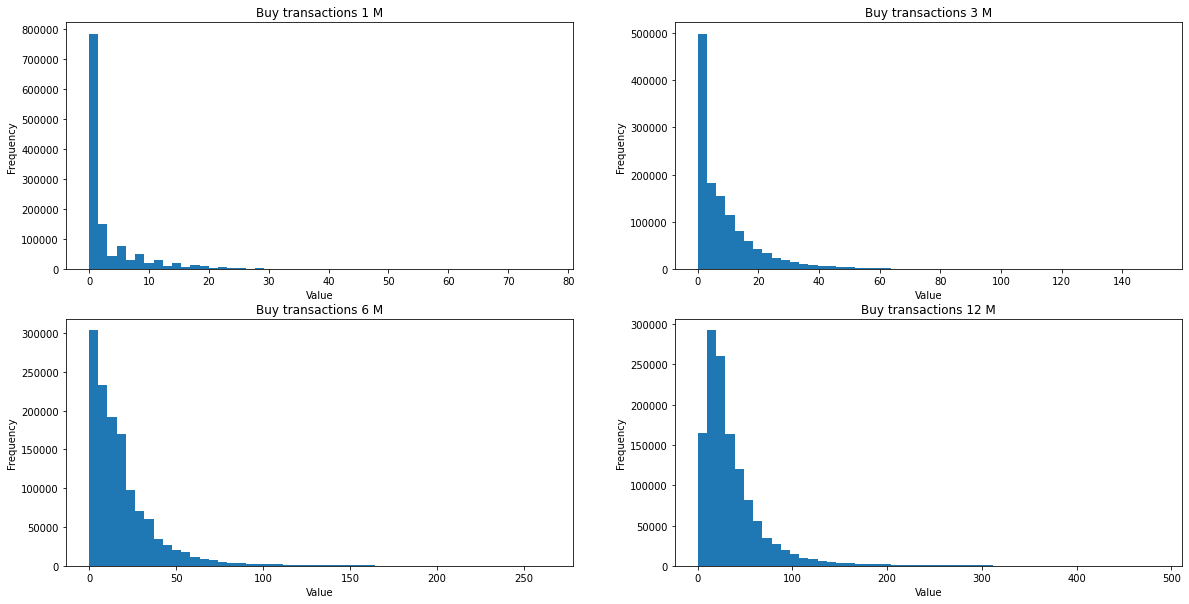

In [ ]:
distribution_plot(train_features, 'buytransactions', 'Buy transactions')

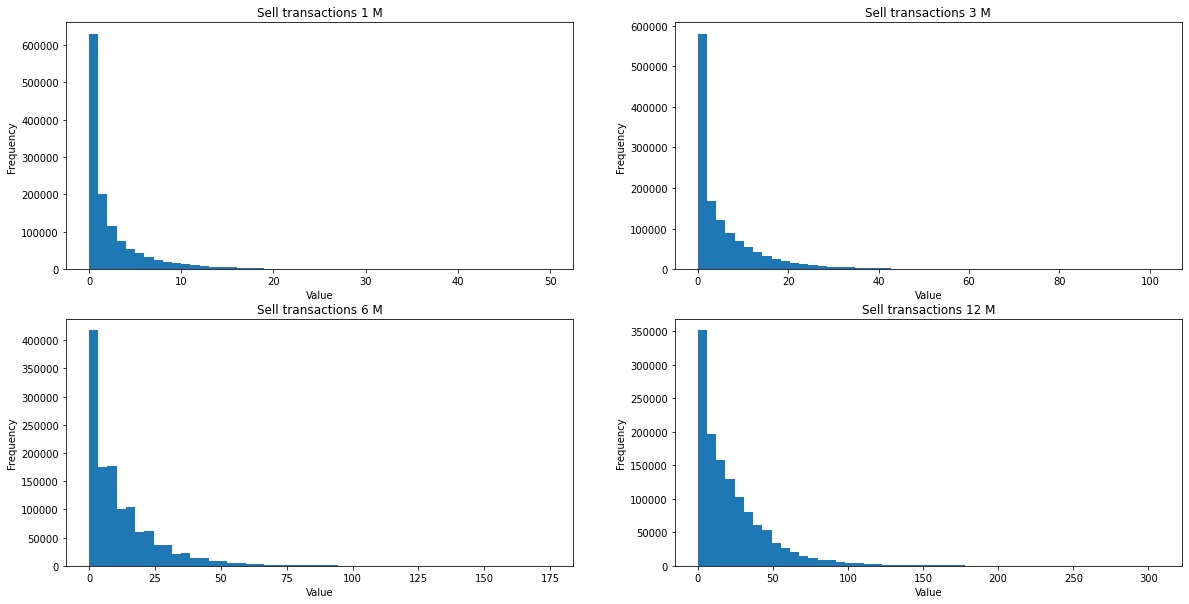

In [ ]:
distribution_plot(train_features, 'selltransactions', 'Sell transactions')

#Buy / Sell shares outliers treatment

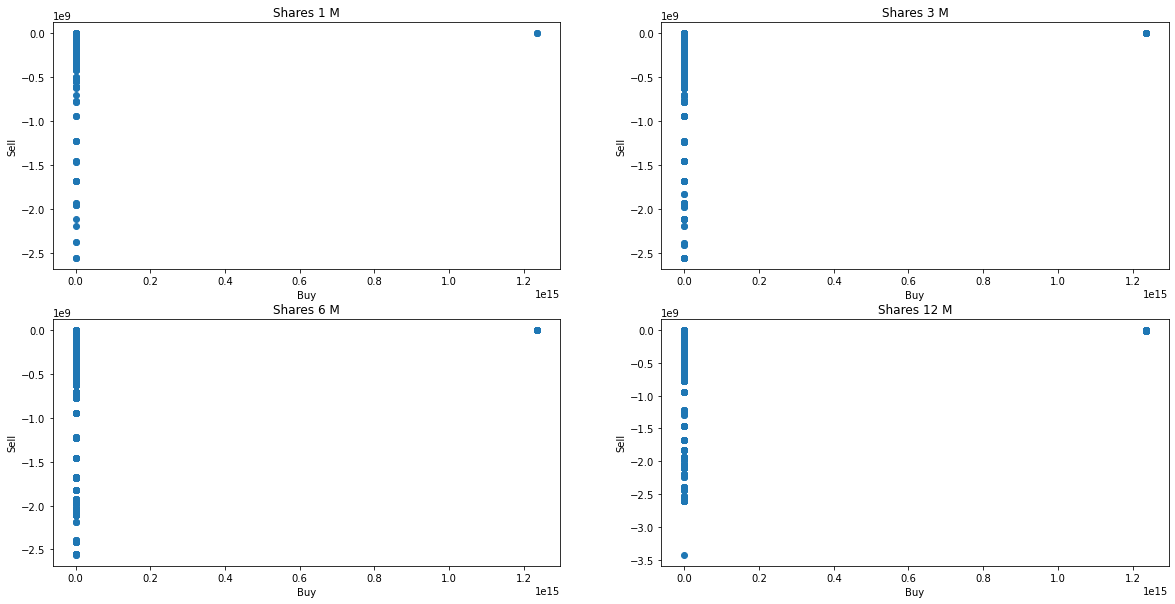

In [ ]:
scatter_plot(train_features, 'buyshares', 'sellshares', 'Shares')

In [ ]:
train_features = drop_outliers(train_features, 'f__buyshares_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buyshares_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buyshares_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buyshares_12m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellshares_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellshares_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellshares_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellshares_12m', threshold=1.5)

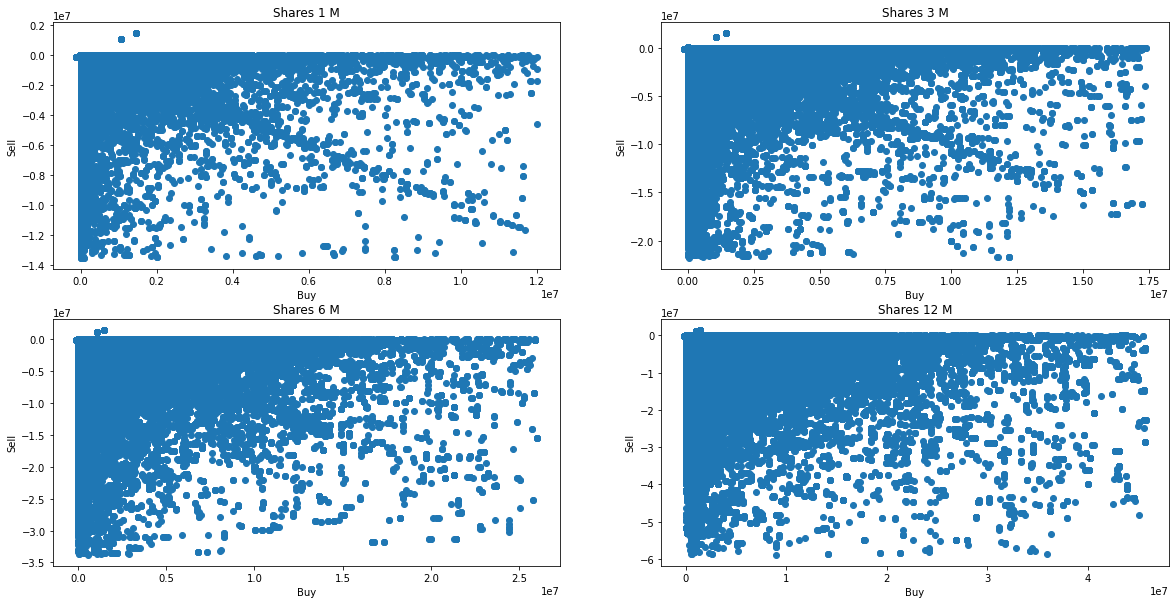

In [ ]:
scatter_plot(train_features, 'buyshares', 'sellshares', 'Shares')

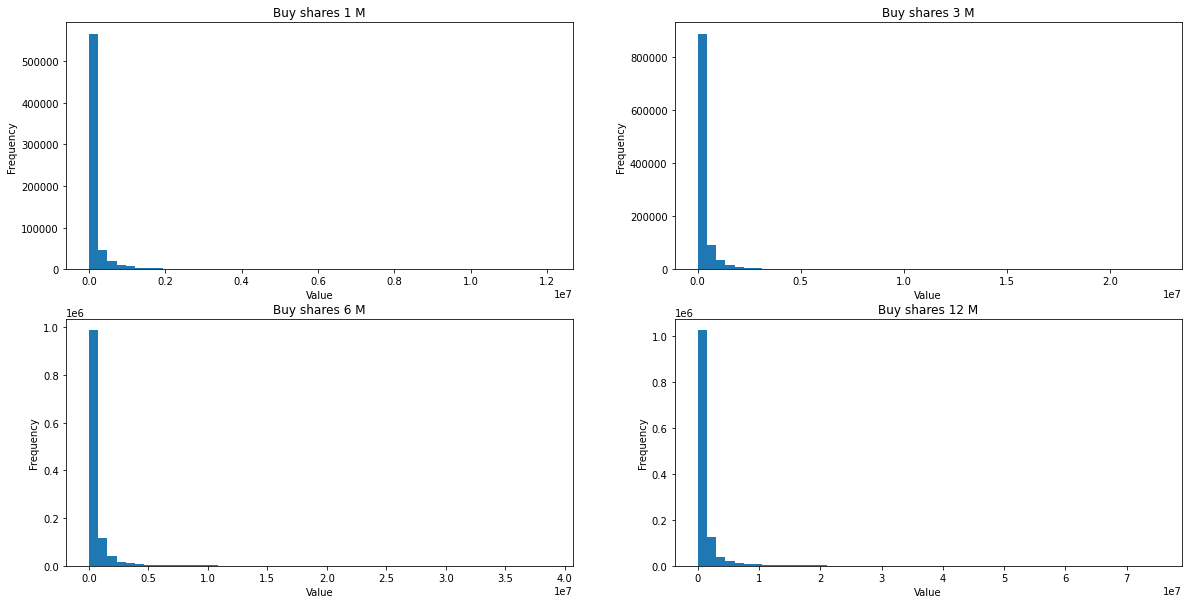

In [ ]:
distribution_plot(train_features, 'buyshares', 'Buy shares')

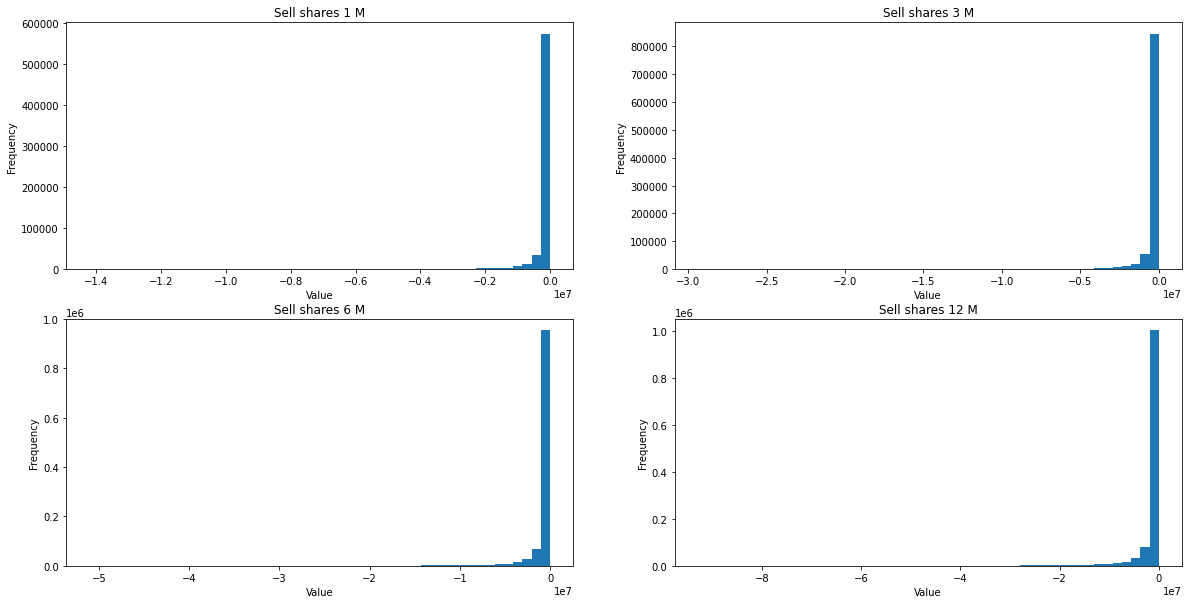

In [ ]:
distribution_plot(train_features, 'sellshares', 'Sell shares')

#Buy / Sell shares % outliers treatment

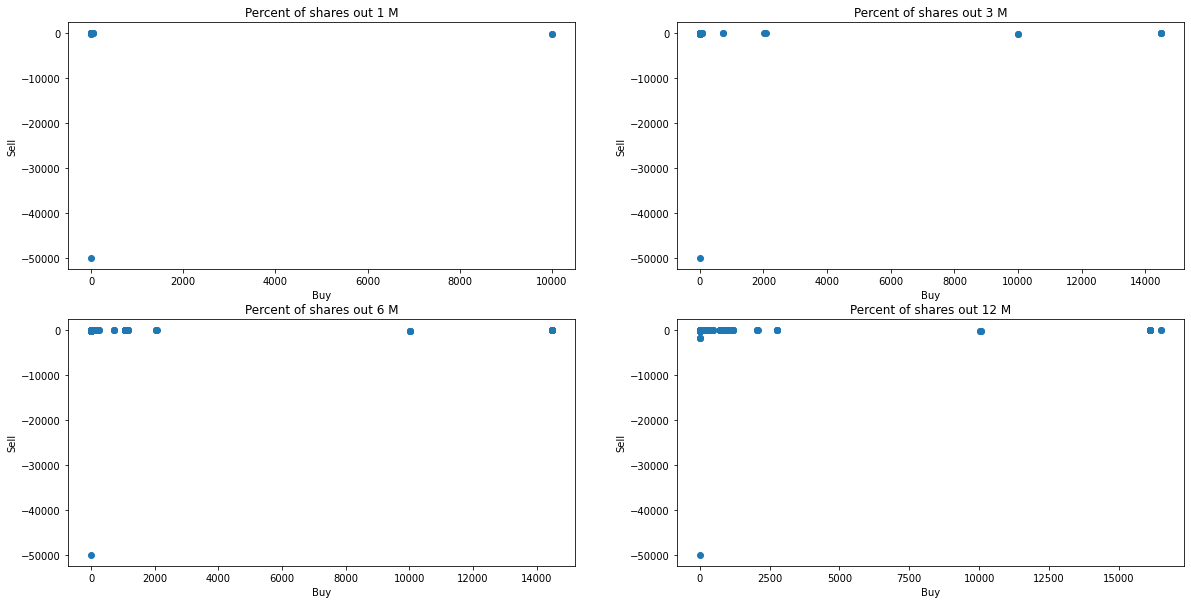

In [ ]:
scatter_plot(train_features, 'buysharespctsharesout', 'sellsharespctsharesout', 'Percent of shares out')

In [ ]:
train_features = drop_outliers(train_features, 'f__buysharespctsharesout_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buysharespctsharesout_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buysharespctsharesout_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__buysharespctsharesout_12m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellsharespctsharesout_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellsharespctsharesout_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellsharespctsharesout_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__sellsharespctsharesout_12m', threshold=1.5)

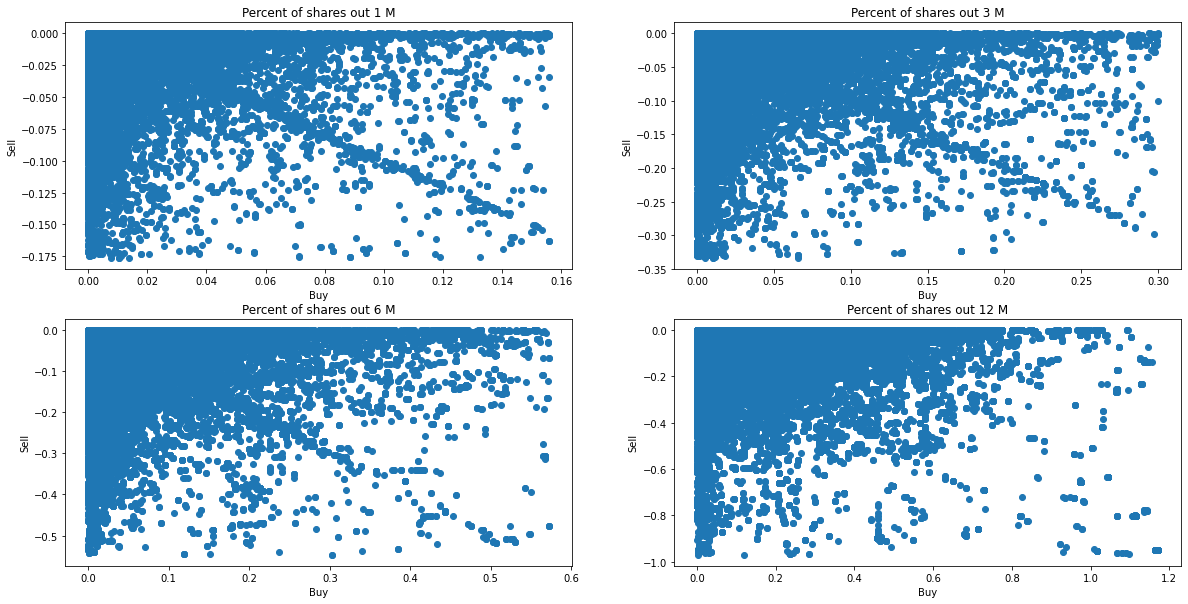

In [ ]:
scatter_plot(train_features, 'buysharespctsharesout', 'sellsharespctsharesout', 'Percent of shares out')

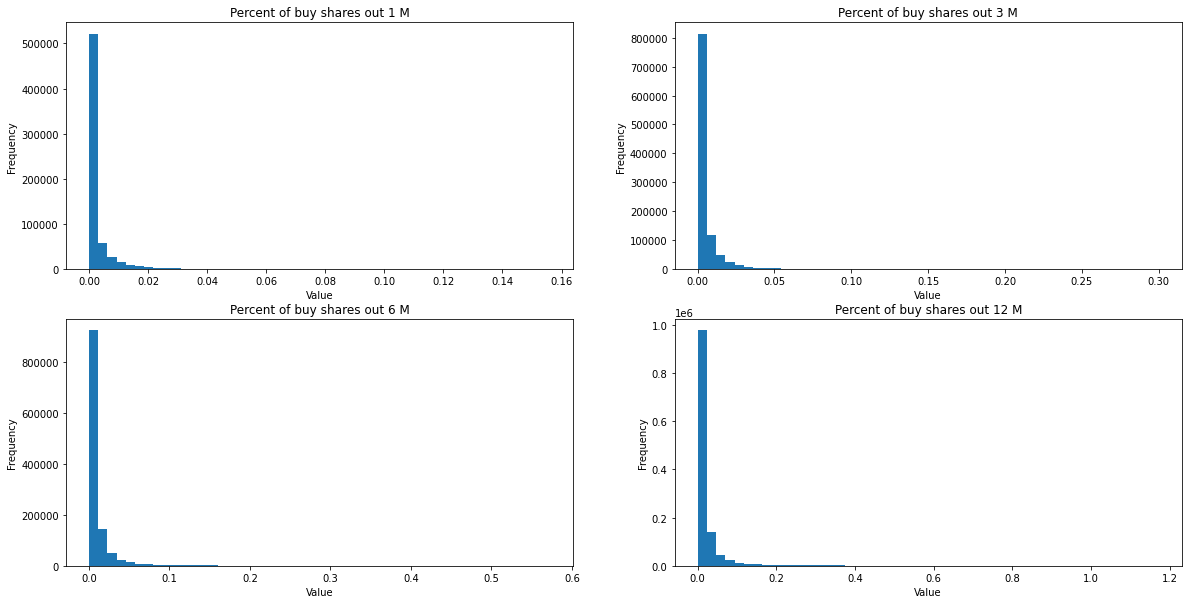

In [ ]:
distribution_plot(train_features, 'buysharespctsharesout', 'Percent of buy shares out')

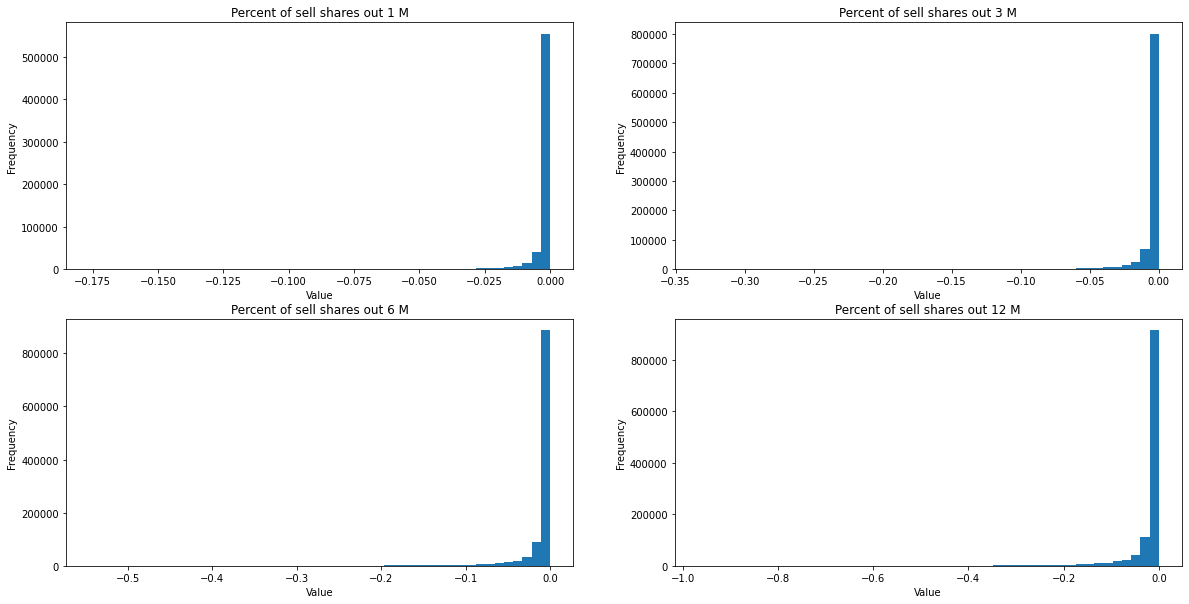

In [ ]:
distribution_plot(train_features, 'sellsharespctsharesout', 'Percent of sell shares out')

#Unique Buyers / Sellers outliers treatment

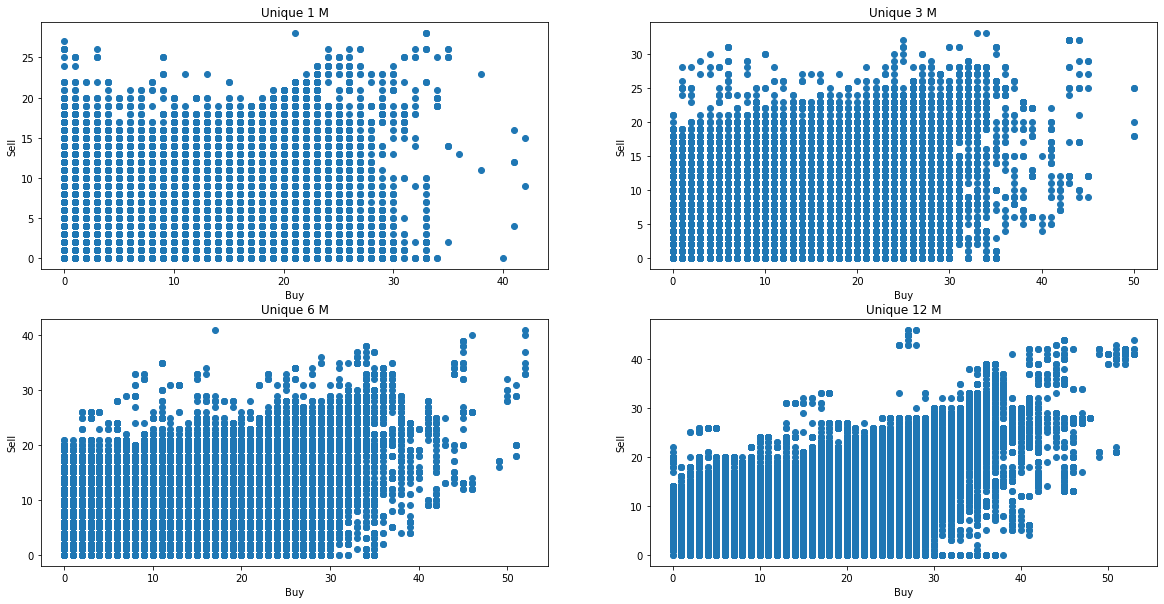

In [ ]:
scatter_plot(train_features, 'uniquebuyers', 'uniquesellers', 'Unique')

In [ ]:
train_features = drop_outliers(train_features, 'f__uniquebuyers_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquebuyers_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquebuyers_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquebuyers_12m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquesellers_1m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquesellers_3m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquesellers_6m', threshold=1.5)
train_features = drop_outliers(train_features, 'f__uniquesellers_12m', threshold=1.5)

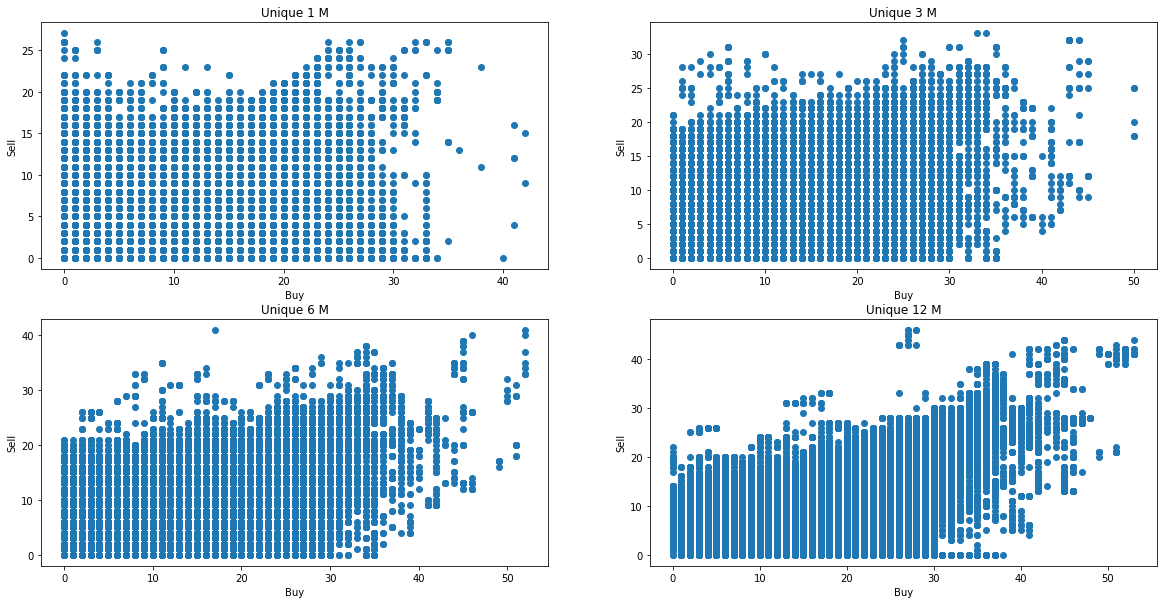

In [ ]:
scatter_plot(train_features, 'uniquebuyers', 'uniquesellers', 'Unique')

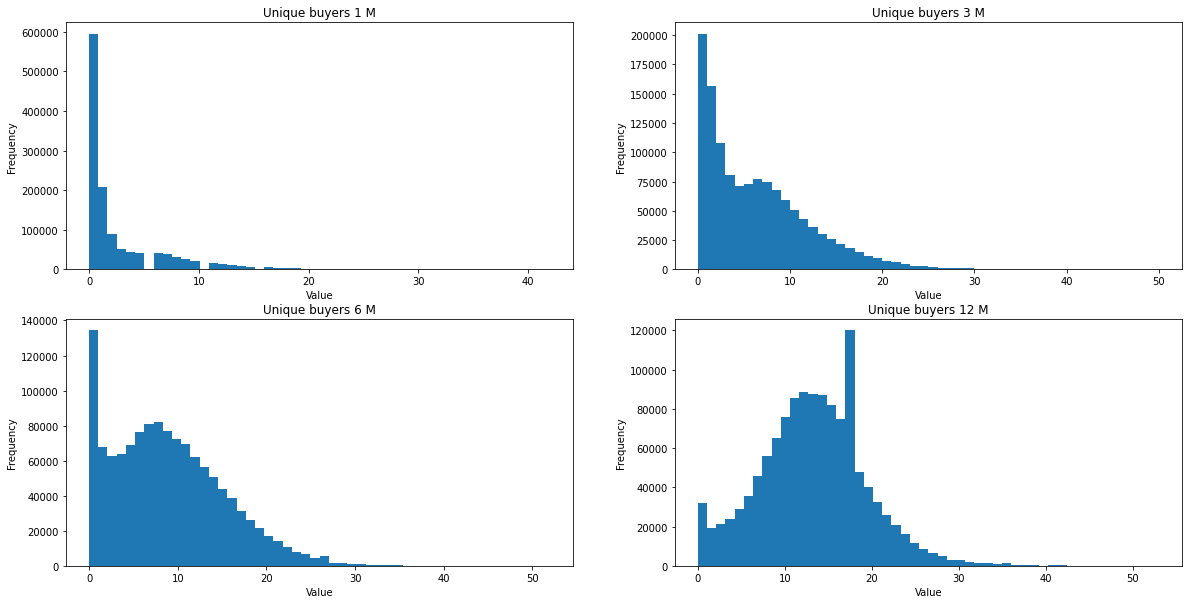

In [ ]:
distribution_plot(train_features, 'uniquebuyers', 'Unique buyers')

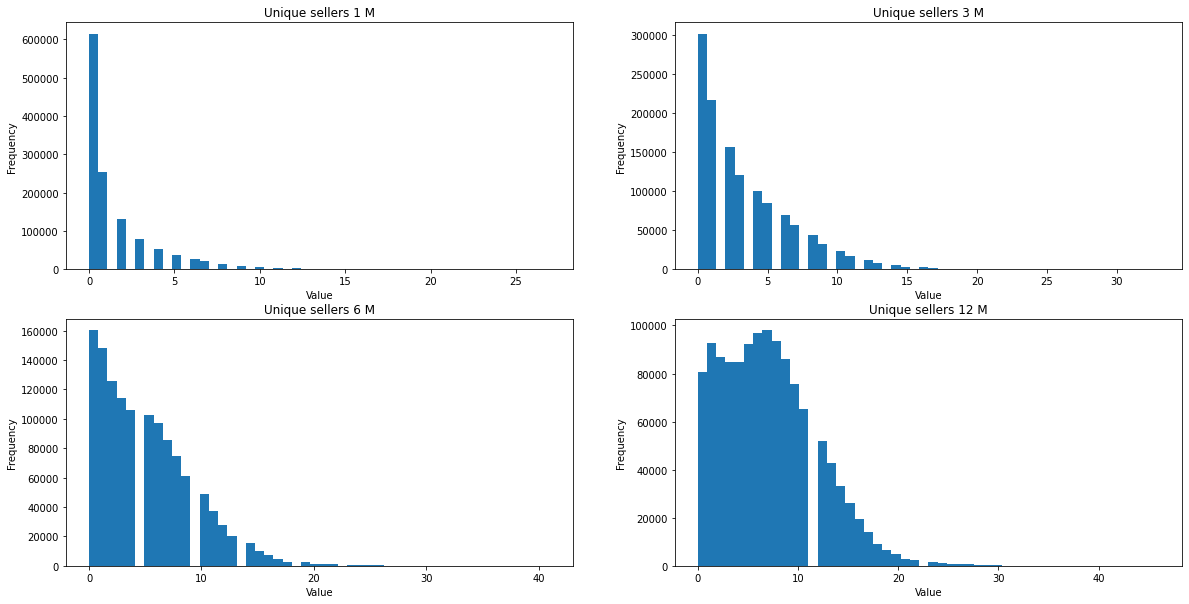

In [ ]:
distribution_plot(train_features, 'uniquesellers', 'Unique sellers')

#Cleaned historical data

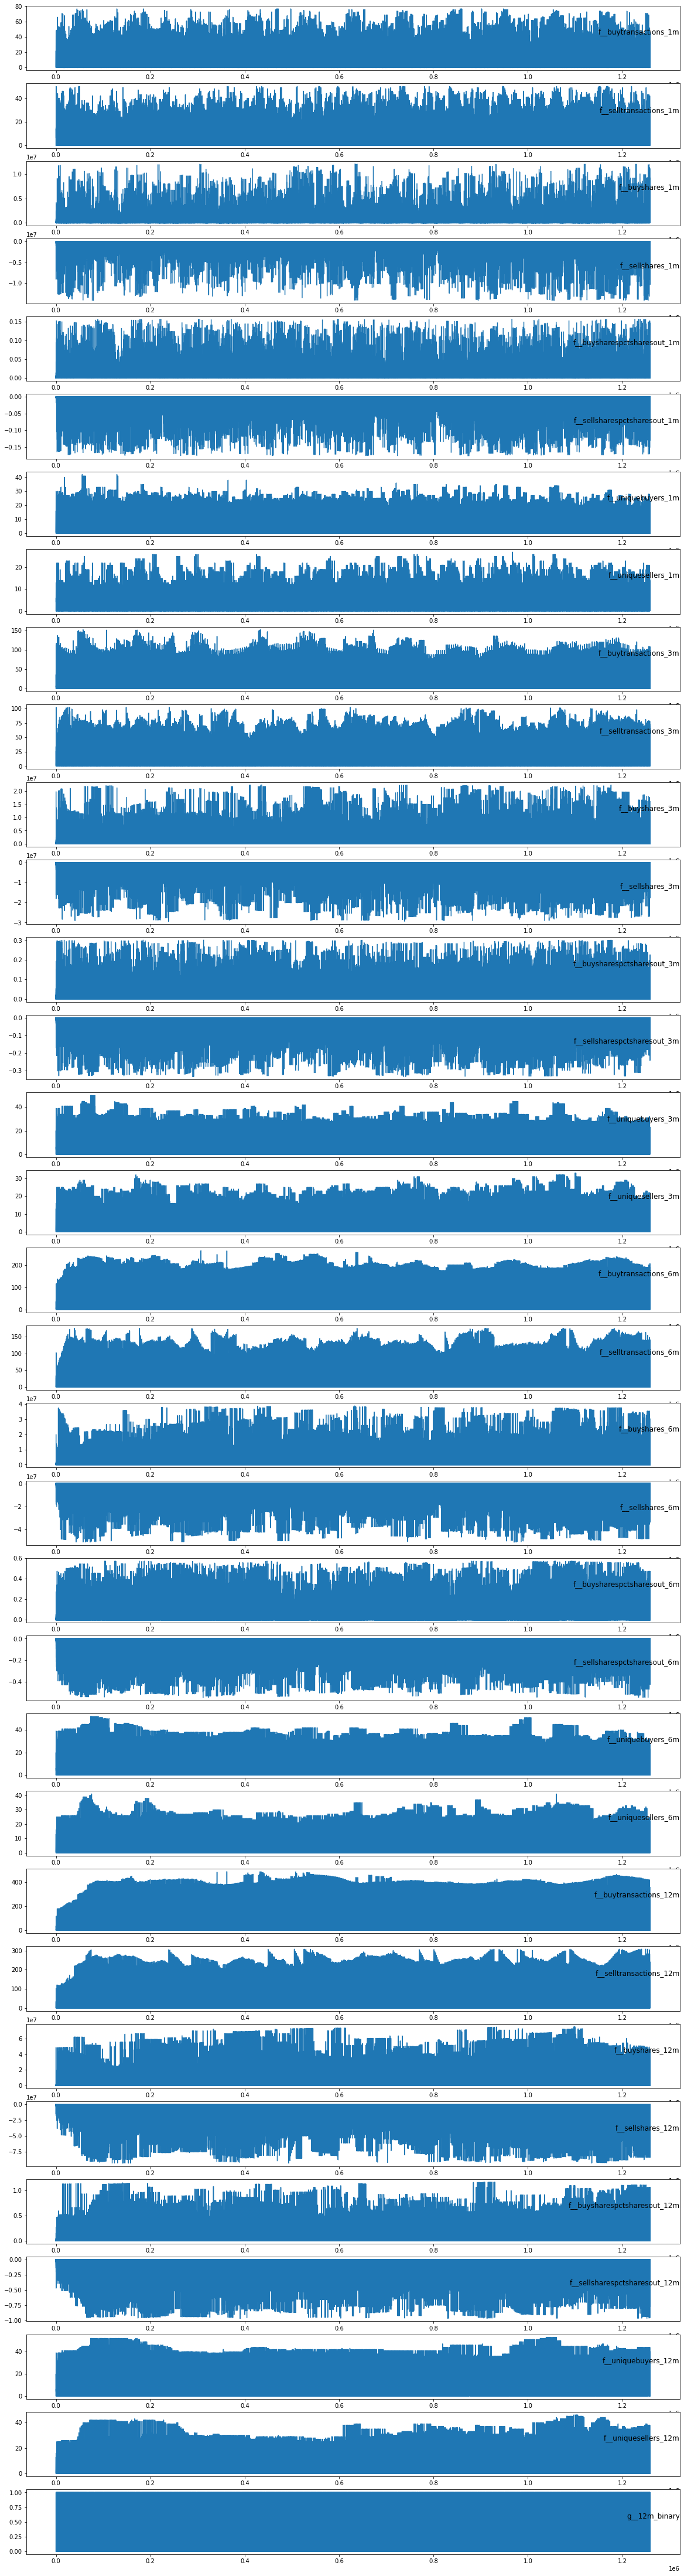

In [ ]:
values = train_features.values
columns = list(range(len(train_features.columns)))
i = 1
plt.figure(figsize=(20, 80))
for column in columns:
    plt.subplot(len(columns), 1, i)
    plt.plot(values[:, column])
    plt.title(train_features.columns[column], y=0.5, loc='right')
    i += 1
plt.show()

#Classes balances

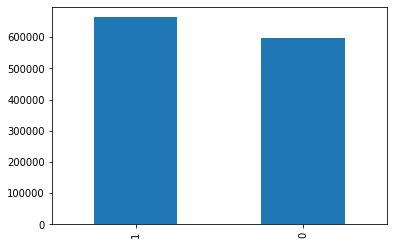

In [ ]:
train_features['g__12m_binary'].value_counts().plot(kind='bar')

#Missing values treatment

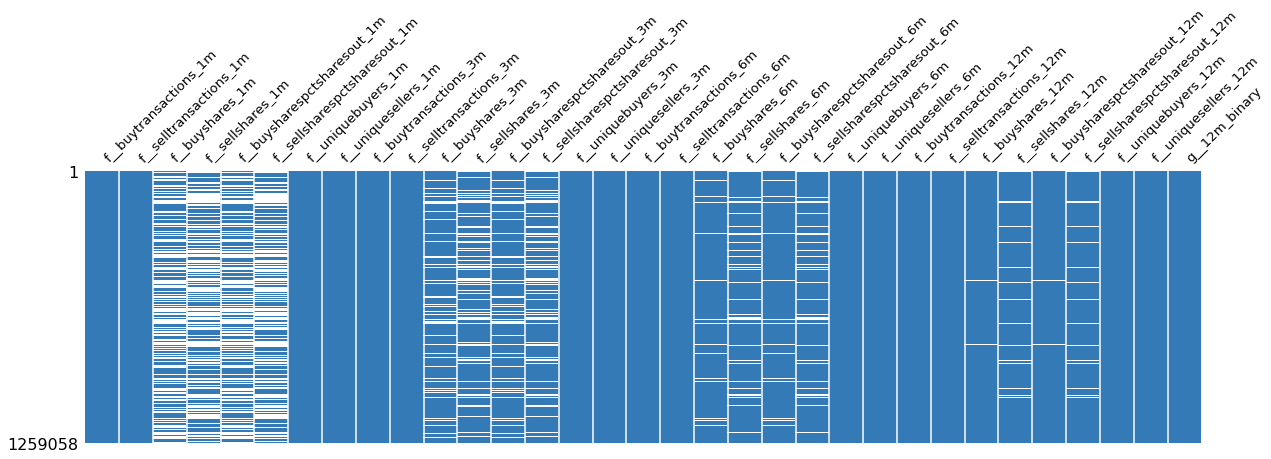

In [ ]:
labels = config["plot"]["missing"]["force_labels"].get(bool)
missingno.matrix(
    train_features,
    figsize=(20, 5),
    color=hex_to_rgb(config["html"]["style"]["primary_color"].get(str)),
    fontsize=get_font_size(train_features) / 10 * 16,
    sparkline=False,
    labels=labels,
)

In [ ]:
train_features = train_features.fillna(train_features.mean())

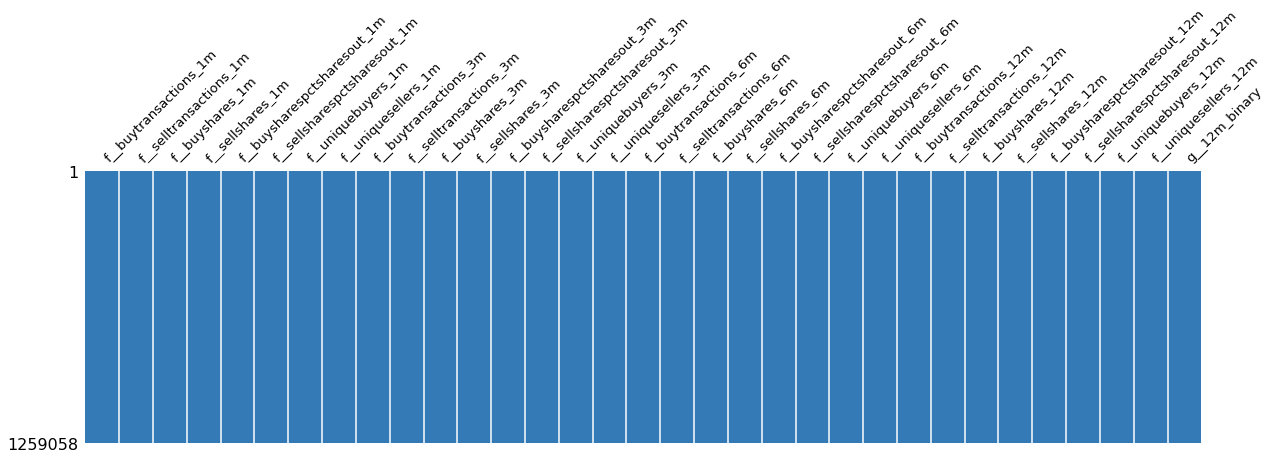

In [ ]:
labels = config["plot"]["missing"]["force_labels"].get(bool)
missingno.matrix(
    train_features,
    figsize=(20, 5),
    color=hex_to_rgb(config["html"]["style"]["primary_color"].get(str)),
    fontsize=get_font_size(train_features) / 10 * 16,
    sparkline=False,
    labels=labels,
)

#Correlation matrix

In [ ]:
columns = [
    'f__buytransactions_1m',
    'f__selltransactions_1m',
    'f__uniquebuyers_1m',
    'f__uniquesellers_1m',
    'f__buyshares_1m',
    'f__sellshares_1m',
    'f__buysharespctsharesout_1m',
    'f__sellsharespctsharesout_1m',
    'f__buytransactions_3m',
    'f__selltransactions_3m',
    'f__uniquebuyers_3m',
    'f__uniquesellers_3m',
    'f__buyshares_3m',
    'f__sellshares_3m',
    'f__buysharespctsharesout_3m',
    'f__sellsharespctsharesout_3m',
    'f__buytransactions_6m',
    'f__selltransactions_6m',
    'f__uniquebuyers_6m',
    'f__uniquesellers_6m',
    'f__buyshares_6m',
    'f__sellshares_6m',
    'f__buysharespctsharesout_6m',
    'f__sellsharespctsharesout_6m',
    'f__buytransactions_6m',
    'f__selltransactions_6m',
    'f__uniquebuyers_12m',
    'f__uniquesellers_12m',
    'f__buyshares_12m',
    'f__sellshares_12m',
    'f__buysharespctsharesout_12m',
    'f__sellsharespctsharesout_12m',
    'g__12m_binary'
]

In [ ]:
data = train_features[columns]

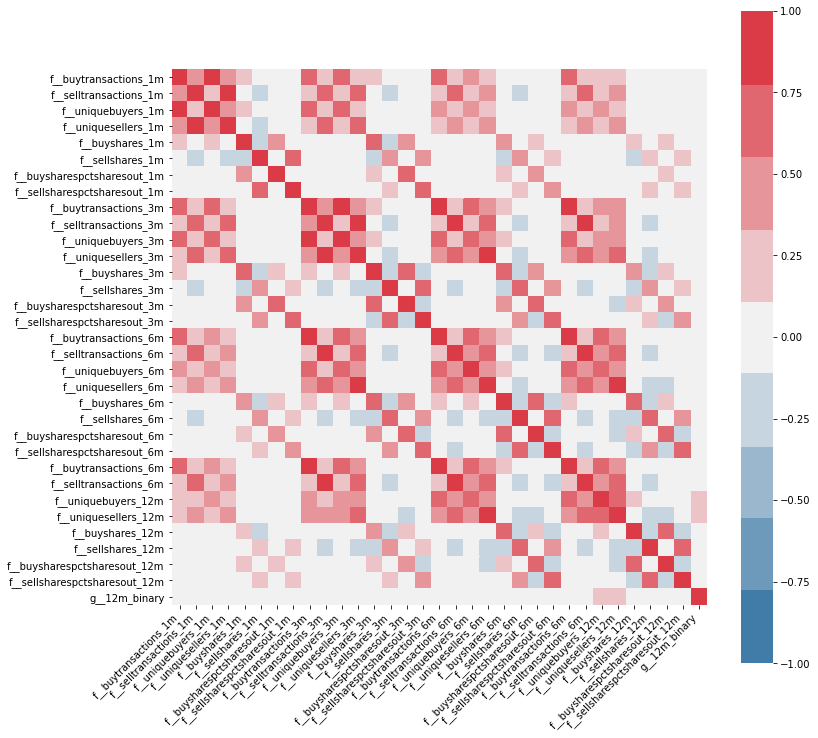

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
corr = data.corr(method='pearson')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 10, n=9),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
import pandas as pd
import ipywidgets
import sympy
import matplotlib.pyplot as plt
import pickle
import copy
from typing import Optional, Union
import numpy as np
import seaborn as sn
from tqdm import tqdm_notebook as tqdm
from scipy.stats import zscore
from scipy import stats
import seaborn as sns
import pandas_profiling
from missingno import missingno
from statistics import median

In [ ]:
!unzip /content/drive/MyDrive/Work/Meson/handout.zip

In [ ]:
train_data = pd.read_pickle('data/train_features.pkl')
test_data = pd.read_pickle('data/test_features.pkl')
data = pd.concat((train_data, test_data), axis=0)
# train_features = train_features.drop_duplicates()

In [ ]:
columns = [
    'f__buytransactions_1m',
    'f__selltransactions_1m',
    'f__uniquebuyers_1m',
    'f__uniquesellers_1m',
    'f__buyshares_1m',
    'f__sellshares_1m',
    'f__buysharespctsharesout_1m',
    'f__sellsharespctsharesout_1m',
    'f__buytransactions_3m',
    'f__selltransactions_3m',
    'f__uniquebuyers_3m',
    'f__uniquesellers_3m',
    'f__buyshares_3m',
    'f__sellshares_3m',
    'f__buysharespctsharesout_3m',
    'f__sellsharespctsharesout_3m',
    'f__buytransactions_6m',
    'f__selltransactions_6m',
    'f__uniquebuyers_6m',
    'f__uniquesellers_6m',
    'f__buyshares_6m',
    'f__sellshares_6m',
    'f__buysharespctsharesout_6m',
    'f__sellsharespctsharesout_6m',
    'f__buytransactions_6m',
    'f__selltransactions_6m',
    'f__uniquebuyers_12m',
    'f__uniquesellers_12m',
    'f__buyshares_12m',
    'f__sellshares_12m',
    'f__buysharespctsharesout_12m',
    'f__sellsharespctsharesout_12m',
]

In [ ]:
def drop_outliers(data, feature_name, threshold=1.5):
    data_preproc = data[[feature_name]]
    
    Q1 = data_preproc.quantile(0.01)
    Q3 = data_preproc.quantile(0.99)
    IQR = Q3 - Q1

    data_outliers = data_preproc[((data_preproc < (Q1 - threshold * IQR)) | (data_preproc > (Q3 + threshold * IQR))).any(axis=1)]
    data.loc[data_outliers.index] = median(data[feature_name])

    return data

In [ ]:
def drop_all_outliers(data, columns):
    for column in columns:
        data = drop_outliers(data, column, threshold=1.5)

    return data

In [ ]:
data = drop_all_outliers(data, columns)

In [ ]:
data = data.fillna(data.mean())

In [ ]:
data = data.reset_index()

#Add moving average

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def add_moving_average(data, columns):
    new_columns = []
    for column in tqdm(columns, total=len(columns)):
        data[f'sme_4_{column}'] = data.groupby(['tradingitemid'])[column].transform(lambda x: x.rolling(4, 1).mean())
        data[f'sme_12_{column}'] = data.groupby(['tradingitemid'])[column].transform(lambda x: x.rolling(12, 1).mean())
        data[f'sme_24_{column}'] = data.groupby(['tradingitemid'])[column].transform(lambda x: x.rolling(24, 1).mean())
        data[f'sme_51_{column}'] = data.groupby(['tradingitemid'])[column].transform(lambda x: x.rolling(51, 1).mean())

    return data

In [ ]:
data = add_moving_average(data, columns)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
with open('/content/drive/MyDrive/Work/Meson/data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
with open('/content/drive/MyDrive/Work/Meson/data.pickle', 'rb') as f:
    data = pickle.load(f)

#Features normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = data.set_index(['date', 'tradingitemid'])

In [ ]:
columns = data.columns

In [ ]:
values = data.values
scaler = MinMaxScaler()
scaler = scaler.fit(values)
values = scaler.transform(values)
data[columns] = values

In [ ]:
train_outcomes = pd.read_pickle('data/train_outcomes.pkl')
data = data.join(train_outcomes)

In [ ]:
train_features = data[~data['g__12m_binary'].isna()]
test_features = data[data['g__12m_binary'].isna()]

In [ ]:
train_features = train_features.reset_index()
test_features = test_features.reset_index()

#Modeling

**Statements**
- Between training and validation samples need to be 1 year gap
- Forward-chaining cross-validation with 1 year step and two year lookback period will be used. 
- Each tradingitemid sequence need to be splited to n samples, where n - it's number of observations of tradingitemid
- Validation dataset in keras training process will have one target for each tradingitemid. And all timestamps features of one tradingitemid are combined to one sequence. This trick is used only to speedup validation inference. For final model validation all targets will be used.
- train_generator produces all samples, while test_generator_fast produces one sample for each tradingitemid
- No zero padding will be used, batch size will be equal to 1

  Alternatives:
  - Zero padding will be used in batch generator, batch size will be equal to m
  - No zero padding will be used, batch size will be equal to m. For each batch need to be generated sequences of       the same length
  
  
- The final predictions will be based on average prediction, based on k models, where k - is number of folds in cross validation.

*Train generator example:*

tradingitemid: [1, 2, 3, 4, 5] -> [1, 0, 1, 0, 1]

[1] -> [1]

[1, 2] -> [0]

[1, 2, 3] -> [1]

[1, 2, 3, 4] -> [0]

[1, 2, 3, 4, 5] -> [1]

*Test generator fast example:*

tradingitemid: [1, 2, 3, 4, 5] -> [1, 0, 1, 0, 1]

[1, 2, 3, 4, 5] - > [1]

In [ ]:
def filter_by_period(data, start_date, end_date):
    after_start_date = data["date"] >= start_date
    before_end_date = data["date"] <= end_date
    data = data.set_index(['date'])
    between_two_dates = list(after_start_date & before_end_date)
    data = data.loc[between_two_dates].reset_index().drop(columns=['date'])
    
    return data

In [ ]:
def train_generator(data):
    num_columns = len(data.columns)
    tradingitemids = set(data.index)
    for tradingitemid in tradingitemids:
        item_data = data.loc[tradingitemid]
        if len(item_data.shape) == 2:
            X_data = item_data.values[:, 0:num_columns-1]
            y_data = item_data.values[:, -1]
            
            num_time_stamps = item_data.shape[0]
            for i in range(num_time_stamps):
                X = X_data[0:i+1, 0:num_columns-1]
                X = X.reshape(1, X.shape[0], X.shape[1])
                Y = np.array(y_data[i]).reshape((-1,1))
                
                yield X, Y
        elif len(item_data.shape) == 1:
            X = item_data[0:num_columns-1].values.reshape((1, -1,num_columns-1))
            Y = item_data[num_columns-1].reshape((-1,1)) 

            yield X, Y

In [ ]:
def test_generator_fast(data):
    num_columns = len(data.columns)
    tradingitemids = set(data.index)
    for tradingitemid in tradingitemids:
        item_data = data.loc[tradingitemid]
        if len(item_data.shape) == 2:
            X = item_data.values[:, 0:num_columns-1]
            X = X.reshape(1, X.shape[0], X.shape[1])
            Y = np.array(item_data.values[-1, -1]).reshape((-1,1))

            yield X, Y

        elif len(item_data.shape) == 1:
            X = item_data[0:num_columns-1].values.reshape((1, -1, num_columns-1))
            Y = item_data[num_columns-1].reshape((-1,1)) 

            yield X, Y

#Define model


In [ ]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class Fold():
    def __init__(self, train_start_date, train_end_date, test_start_date, test_end_date):
        self.train_start_date = train_start_date
        self.train_end_date = train_end_date
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date

In [ ]:
cross_validation_config = [
    Fold("2004-01-01", "2005-12-31", "2007-01-01", "2007-12-31"),
    Fold("2005-01-01", "2006-12-31", "2008-01-01", "2008-12-31"),
    Fold("2006-01-01", "2007-12-31", "2009-01-01", "2009-12-31"),
    Fold("2007-01-01", "2008-12-31", "2010-01-01", "2010-12-31"),
    Fold("2008-01-01", "2009-12-31", "2011-01-01", "2011-12-31"),
    Fold("2009-01-01", "2010-12-31", "2012-01-01", "2012-12-31"),
    
    # Hold out period
    # Fold("2010-01-01", "2011-12-31", "2013-01-01", "2013-12-31"),
    # Fold("2011-01-01", "2012-12-31", "2014-01-01", "2014-12-31"),
    # Fold("2012-01-01", "2013-12-31", "2015-01-01", "2015-12-31"),
]

In [ ]:
train_features

,date,tradingitemid,f__buytransactions_1m,f__selltransactions_1m,f__buyshares_1m,f__sellshares_1m,f__buysharespctsharesout_1m,f__sellsharespctsharesout_1m,f__uniquebuyers_1m,f__uniquesellers_1m,f__buytransactions_3m,f__selltransactions_3m,f__buyshares_3m,f__sellshares_3m,f__buysharespctsharesout_3m,f__sellsharespctsharesout_3m,f__uniquebuyers_3m,f__uniquesellers_3m,f__buytransactions_6m,f__selltransactions_6m,f__buyshares_6m,f__sellshares_6m,f__buysharespctsharesout_6m,f__sellsharespctsharesout_6m,f__uniquebuyers_6m,f__uniquesellers_6m,f__buytransactions_12m,f__selltransactions_12m,f__buyshares_12m,f__sellshares_12m,f__buysharespctsharesout_12m,f__sellsharespctsharesout_12m,f__uniquebuyers_12m,f__uniquesellers_12m,sme_4_f__buytransactions_1m,sme_12_f__buytransactions_1m,sme_24_f__buytransactions_1m,sme_51_f__buytransactions_1m,sme_4_f__selltransactions_1m,sme_12_f__selltransactions_1m,...,sme_12_f__buyshares_6m,sme_24_f__buyshares_6m,sme_51_f__buyshares_6m,sme_4_f__sellshares_6m,sme_12_f__sellshares_6m,sme_24_f__sellshares_6m,sme_51_f__sellshares_6m,sme_4_f__buysharespctsharesout_6m,sme_12_f__buysharespctsharesout_6m,sme_24_f__buysharespctsharesout_6m,sme_51_f__buysharespctsharesout_6m,sme_4_f__sellsharespctsharesout_6m,sme_12_f__sellsharespctsharesout_6m,sme_24_f__sellsharespctsharesout_6m,sme_51_f__sellsharespctsharesout_6m,sme_4_f__uniquebuyers_12m,sme_12_f__uniquebuyers_12m,sme_24_f__uniquebuyers_12m,sme_51_f__uniquebuyers_12m,sme_4_f__uniquesellers_12m,sme_12_f__uniquesellers_12m,sme_24_f__uniquesellers_12m,sme_51_f__uniquesellers_12m,sme_4_f__buyshares_12m,sme_12_f__buyshares_12m,sme_24_f__buyshares_12m,sme_51_f__buyshares_12m,sme_4_f__sellshares_12m,sme_12_f__sellshares_12m,sme_24_f__sellshares_12m,sme_51_f__sellshares_12m,sme_4_f__buysharespctsharesout_12m,sme_12_f__buysharespctsharesout_12m,sme_24_f__buysharespctsharesout_12m,sme_51_f__buysharespctsharesout_12m,sme_4_f__sellsharespctsharesout_12m,sme_12_f__sellsharespctsharesout_12m,sme_24_f__sellsharespctsharesout_12m,sme_51_f__sellsharespctsharesout_12m,g__12m_binary
0,2004-08-06,2585893,0.015004,0.000128,0.000627,0.989604,0.024758,0.936659,0.026453,0.000215,0.047284,0.023049,0.000479,0.994286,0.011383,0.961204,0.120095,0.031413,0.027674,0.013830,0.000337,0.996000,0.006845,0.972916,0.115476,0.025131,0.004336,0.001493,0.000198,0.997598,0.004351,0.983602,0.100081,0.021388,0.015004,0.017039,0.017039,0.017039,0.000129,0.000136,...,0.000337,0.000338,0.000338,0.995993,0.995972,0.995353,0.994608,0.006845,0.006845,0.006898,0.006898,0.972905,0.972865,0.969796,0.969796,0.103087,0.109178,0.115476,0.117155,0.021853,0.022134,0.022654,0.023757,0.000198,0.000198,0.000199,0.000208,0.997593,0.997563,0.997549,0.997191,0.004351,0.004351,0.004532,0.004532,0.983600,0.983578,0.983373,0.979271,0.0
1,2004-08-06,2585895,0.029929,0.071547,0.000805,0.999960,0.025846,0.950197,0.052765,0.120189,0.031537,0.046036,0.000696,0.999971,0.011992,0.967928,0.060101,0.093902,0.018457,0.027622,0.000489,0.999979,0.007211,0.977610,0.057790,0.075124,0.002892,0.002982,0.000288,0.999988,0.004584,0.986443,0.050085,0.063937,0.029929,0.033986,0.033986,0.033986,0.072409,0.076075,...,0.000489,0.000492,0.000492,0.999979,0.999979,0.999976,0.999972,0.007211,0.007211,0.007267,0.007267,0.977601,0.977568,0.975031,0.975031,0.051590,0.054638,0.057790,0.058630,0.065327,0.066166,0.067718,0.071017,0.000288,0.000288,0.000289,0.000302,0.999988,0.999987,0.999987,0.999986,0.004584,0.004584,0.004774,0.004774,0.986443,0.986424,0.986255,0.982863,1.0
2,2004-08-06,2585941,0.000080,0.000128,0.011687,0.989604,0.041249,0.936659,0.000141,0.000215,0.000042,0.000062,0.016669,0.985570,0.026210,0.950004,0.000107,0.000168,0.000025,0.000037,0.021657,0.981923,0.024082,0.955055,0.000103,0.000134,0.000004,0.000004,0.025619,0.978799,0.026125,0.960044,0.000090,0.000114,0.000080,0.000091,0.000091,0.000091,0.000129,0.000136,...,0.021664,0.021762,0.021762,0.981892,0.981799,0.979000,0.975632,0.024082,0.024082,0.024270,0.024270,0.955037,0.954971,0.949878

In [ ]:
folds_scores = []
for fold_id, fold in enumerate(cross_validation_config):
    tf.compat.v1.reset_default_graph()
    inputs = keras.Input(shape=(None, len(train_features.columns)-1), dtype="float32")
    x = layers.LSTM(32)(inputs)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", metrics=tf.keras.metrics.AUC(), optimizer='adam')

    train_data = filter_by_period(train_features, fold.train_start_date, fold.train_end_date)
    test_data = filter_by_period(train_features, fold.test_start_date, fold.test_end_date)

    num_test_items = len(test_data['tradingitemid'].unique())
    train_data = train_data.set_index(['tradingitemid'])
    test_data = test_data.set_index(['tradingitemid'])

    scores_log = []
    partition_size = 1000
    best_loss = np.inf
    num_partitions = int(train_data.shape[0] / partition_size)

    print(f'\n Fold {fold_id} training started...')
    for epoch in range(1):
        for i in tqdm(range(num_partitions), total=num_partitions):
            train_data_partition = train_data.iloc[i * partition_size : (i + 1) * partition_size]
            train_gen = train_generator(train_data_partition)
            test_gen = test_generator_fast(test_data)
            scores = model.fit(train_gen, epochs=1, steps_per_epoch=partition_size, validation_data=test_gen, validation_steps=num_test_items, verbose=1)
            val_loss = scores.history['val_loss'][0]
            train_loss = scores.history['loss'][0]
            loss = (val_loss + train_loss) / 2
            scores_log.append(loss)
            if loss  < best_loss:
                model.save_weights(f'/content/drive/MyDrive/Work/Meson/lstm_last_fold_{fold_id}.weights')
                best_loss = loss
                print(f'Best model saved! Scores: {scores.history}')
    folds_scores.append(scores_log)

In [ ]:
for scores in folds_scores:
    plt.plot(scores)
    plt.show()

#Load model

In [ ]:
class Ansemple():
    def __init__(self):
        self.models = []

    def _build_model(self):
        tf.compat.v1.reset_default_graph()
        inputs = keras.Input(shape=(None, 32), dtype="float32")
        x = layers.LSTM(64)(inputs)
        outputs = layers.Dense(1, activation="sigmoid")(x)
        keras_model = keras.Model(inputs, outputs)
        keras_model.compile(loss="binary_crossentropy", metrics=tf.keras.metrics.AUC(), optimizer='adam')

        return keras_model

    def load_models(self, base_model_path, num_folds, num_skip=0):
        for fold_id in range(num_folds):
            fold_id = fold_id + num_skip
            keras_model = self._build_model()
            keras_model.load_weights(f'{base_model_path}_{fold_id}.weights')
            self.models.append(keras_model)

    def predict(self, test_data, generator, num_steps):
        predictions = []
        for keras_model in self.models:
            gen = generator(test_data)
            single_model_predictions = keras_model.predict_generator(gen, steps=num_steps, verbose=1)
            predictions.append(single_model_predictions)
        
        preds_arr = np.array(predictions).squeeze()
        mean_predictions = np.mean(preds_arr, axis=0)

        return mean_predictions

In [ ]:
ansamble = Ansemple()
ansamble.load_models('/content/drive/MyDrive/Work/Meson/lstm_best_loss_fold_', num_folds=5)

#Model evaluation

In [ ]:
from sklearn.metrics import *
from sklearn.calibration import calibration_curve
from mlxtend.evaluate import lift_score

In [ ]:
def evaluate_classifier(y, y_pred, logits, labels=['Positives','Negatives']):
    pos_p = y_pred.squeeze()
    
    #FIGURE
    plt.figure(figsize=[25,6])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':logits.squeeze(), 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y, logits)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

In [ ]:
def lift (test, pred, cardinaility):
    test = np.array(test)
    res = pd.DataFrame(np.column_stack((test, pred)),
                       columns=['Target','PR_0'])

    res['scr_grp'] = pd.qcut(res['PR_0'], cardinaility, duplicates='drop', labels=False)+1

    crt = pd.crosstab(res.scr_grp, res.Target).reset_index()
    crt = crt.rename(columns= {'Target':'Np',0.0: 'Negatives', 1.0: 'Positives'})

    G = crt['Positives'].sum()
    B = crt['Negatives'].sum()
   
    avg_resp_rate = G/(G+B)

    crt['positive_rate'] = round(crt['Positives']/(crt['Positives']+crt['Negatives']),2)
    crt['lift'] = round((crt['positive_rate']/avg_resp_rate),2)
    crt['rand_resp'] = 1/cardinaility
    crt['cmltv_p'] = round((crt['Positives']).cumsum(),2)
    crt['cmltv_p_perc'] = round(((crt['Positives']/G).cumsum())*100,1)
    crt['cmltv_n'] = round((crt['Negatives']).cumsum(),2)  
    crt['cmltv_n_perc'] = round(((crt['Negatives']/B).cumsum())*100,1)   
    crt['cmltv_rand_p_perc'] = (crt.rand_resp.cumsum())*100
    crt['cmltv_positive_rate'] = round(crt['cmltv_p']/(crt['cmltv_p']+crt['cmltv_n']),2)   
    crt['cmltv_lift'] = round(crt['cmltv_positive_rate']/avg_resp_rate,2)
    crt['KS']=round(crt['cmltv_p_perc']-crt['cmltv_rand_p_perc'],2)
    crt = crt.drop(['rand_resp','cmltv_p','cmltv_n',], axis=1)
    columns = [
        'Negatives',
        'Positives',
        'positive_rate',
        'lift'
    ]
    crt = crt[columns]
    
    return crt

In [ ]:
def calculate_lift(y_true, predictions):
    average_rate = sum(y_true) / len(y_true)

    decile_count = int(num_test_items / 10)
    top_high_decile_indexes = np.argsort(predictions, axis=0)[-decile_count::]
    top_low_decile_indexes = np.argsort(predictions, axis=0)[:decile_count]
    top_high_decile_y = y_true[top_high_decile_indexes]
    top_low_decile_y = y_true[top_low_decile_indexes]
    high_decile_lift = (sum(top_high_decile_y) / len(top_high_decile_y)) / average_rate
    low_decile_lift = (sum(top_low_decile_y) / len(top_low_decile_y)) / average_rate

    centile_count = int(num_test_items / 100)
    top_high_centile_indexes = np.argsort(predictions, axis=0)[-centile_count::]
    top_low_centile_indexes = np.argsort(predictions, axis=0)[:centile_count]
    top_high_centile_y = y_true[top_high_centile_indexes]
    top_low_centile_y = y_true[top_low_centile_indexes]
    high_centile_lift = (sum(top_high_centile_y) / len(top_high_centile_y)) / average_rate
    low_centile_lift = (sum(top_low_centile_y) / len(top_low_centile_y)) / average_rate

    print(f'High decile lift: {high_decile_lift}')
    print(f'Low decile lift: {low_decile_lift}')
    print(f'High centile lift: {high_centile_lift}')
    print(f'Low centile lift: {low_centile_lift}')

In [ ]:
def plot_calibration_curve(y_true, predictions):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, predictions, normalize=True, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives)
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

#Generate ground truth

In [ ]:
test_data = filter_by_period(train_features, "2013-01-01", "2013-12-31")
num_test_items = len(test_data)
test_data = test_data.set_index('tradingitemid')
y_true = []
test_gen = train_generator(test_data)
for i in range(num_test_items):
    y_true.append(int(next(test_gen)[1][0][0]))

#LogLoss of random predictions

In [ ]:
tf.compat.v1.reset_default_graph()
inputs = keras.Input(shape=(None, 32), dtype="float32")
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1, activation="sigmoid")(x)
keras_model = keras.Model(inputs, outputs)
keras_model.compile(loss="binary_crossentropy", metrics=tf.keras.metrics.AUC(), optimizer='adam')

In [ ]:
test_gen = train_generator(test_data)
predictions = keras_model.predict_generator(test_gen, steps=num_test_items, verbose=1).squeeze()
y_pred = np.array((predictions>0.5), dtype='int32')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 200s 2ms/step


In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.7918533637309296


#Fold 1 evaluation

In [ ]:
test_gen = train_generator(test_data)
predictions = ansamble.models[0].predict_generator(test_gen, steps=num_test_items, verbose=1).squeeze()
y_pred = np.array((predictions>0.5), dtype='int32')

    94/107511 [..............................] - ETA: 2:57

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 188s 2ms/step


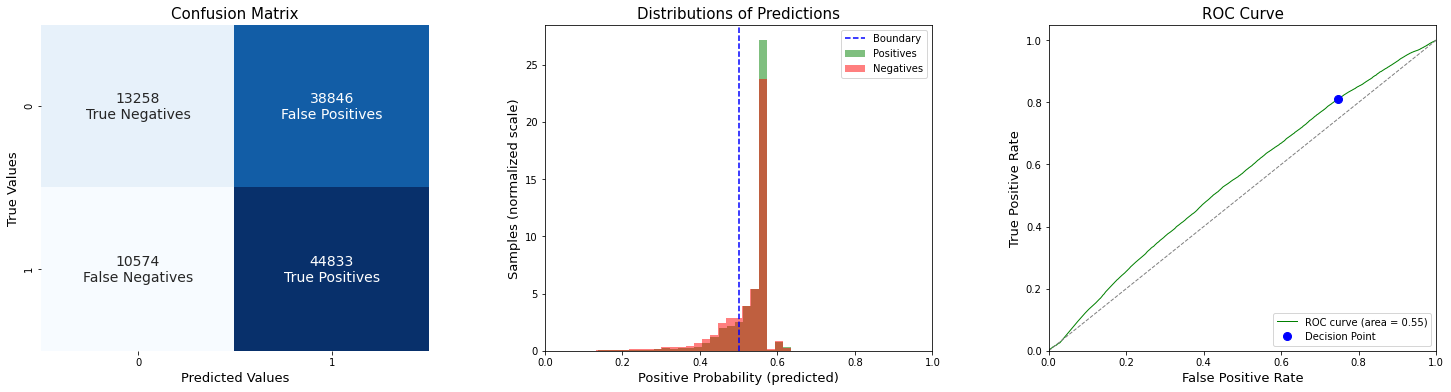

Precision: 0.54 | Recall: 0.81 | F1 Score: 0.64 | 


0.644680269761155

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,6188,4564,0.42,0.81
1,5853,4898,0.46,0.89
2,5369,5382,0.50,0.97
3,5424,5327,0.50,0.97
4,5262,5489,0.51,0.99
5,5038,5713,0.53,1.03
6,5117,5637,0.52,1.01
7,4805,5946,0.55,1.07
8,5121,7178,0.58,1.13
9,3927,5273,0.57,1.11


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,648,428,0.40,0.78
1,577,498,0.46,0.89
2,632,443,0.41,0.80
3,650,425,0.40,0.78
4,713,362,0.34,0.66
...,...,...,...,...
89,987,1475,0.60,1.16
90,2406,3811,0.61,1.18
91,442,390,0.47,0.91
92,600,475,0.44,0.85


No handles with labels found to put in legend.


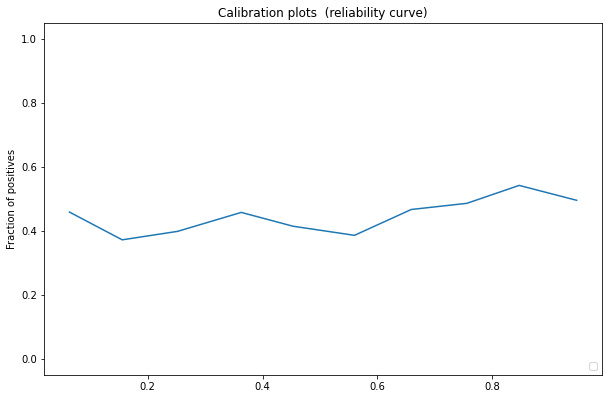

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.6915275624323675


#Fold 2 evaluation

In [ ]:
test_gen = train_generator(test_data)
predictions = ansamble.models[1].predict_generator(test_gen, steps=num_test_items, verbose=1).squeeze()
y_pred = np.array((predictions>0.5), dtype='int32')

    92/107511 [..............................] - ETA: 3:00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 196s 2ms/step


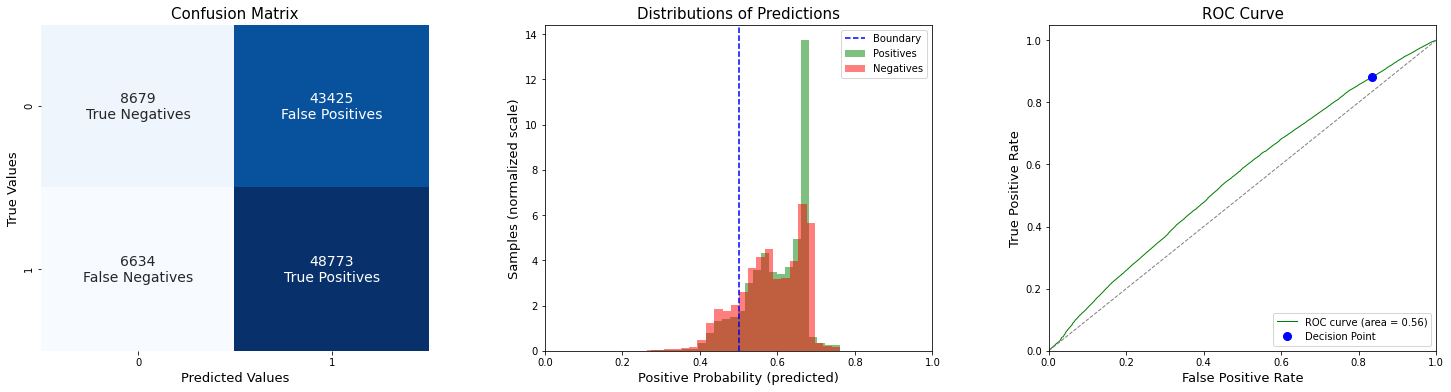

Precision: 0.53 | Recall: 0.88 | F1 Score: 0.66 | 


0.6608583720063683

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,6174,4578,0.43,0.83
1,5928,4823,0.45,0.87
2,5472,5279,0.49,0.95
3,5547,5212,0.48,0.93
4,5252,5491,0.51,0.99
5,4957,5794,0.54,1.05
6,4883,5868,0.55,1.07
7,4993,5758,0.54,1.05
8,4603,6148,0.57,1.11
9,4295,6456,0.60,1.16


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,702,374,0.35,0.68
1,629,446,0.41,0.80
2,629,446,0.41,0.80
3,628,447,0.42,0.81
4,594,481,0.45,0.87
...,...,...,...,...
95,491,779,0.61,1.18
96,265,614,0.70,1.36
97,521,554,0.52,1.01
98,483,592,0.55,1.07


No handles with labels found to put in legend.


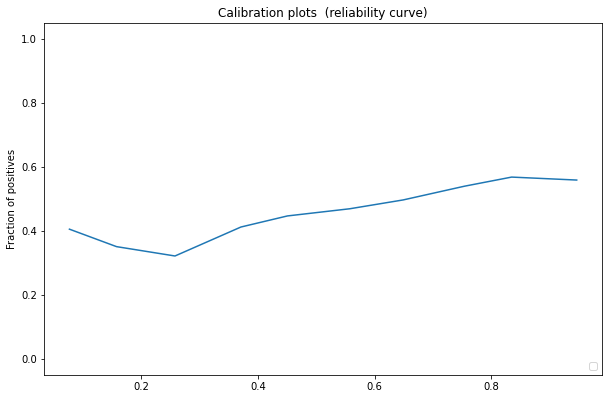

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.7023116141232535


#Fold 3 evaluation

In [ ]:
test_gen = train_generator(test_data)
predictions = ansamble.models[2].predict_generator(test_gen, steps=num_test_items, verbose=1).squeeze()
y_pred = np.array((predictions>0.5), dtype='int32')

    88/107511 [..............................] - ETA: 3:09

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 196s 2ms/step


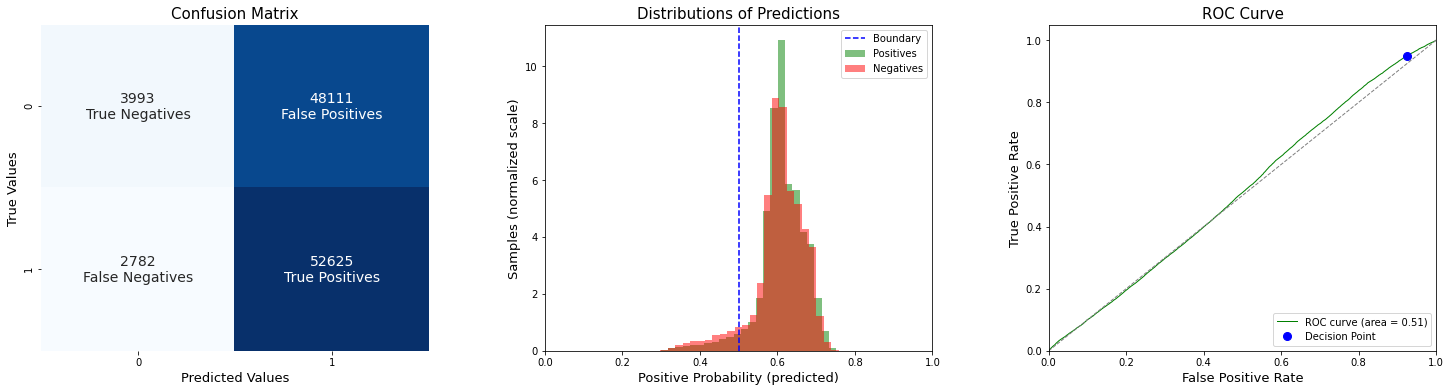

Precision: 0.52 | Recall: 0.95 | F1 Score: 0.67 | 


0.6740615973818871

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,6065,4687,0.44,0.85
1,5344,5407,0.50,0.97
2,5081,5670,0.53,1.03
3,5068,5683,0.53,1.03
4,4749,6002,0.56,1.09
5,4919,5832,0.54,1.05
6,5174,5577,0.52,1.01
7,5144,5607,0.52,1.01
8,5349,5402,0.50,0.97
9,5211,5540,0.52,1.01


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,640,436,0.41,0.80
1,646,429,0.40,0.78
2,633,442,0.41,0.80
3,612,463,0.43,0.83
4,623,452,0.42,0.81
...,...,...,...,...
95,564,511,0.48,0.93
96,556,519,0.48,0.93
97,471,604,0.56,1.09
98,493,582,0.54,1.05


No handles with labels found to put in legend.


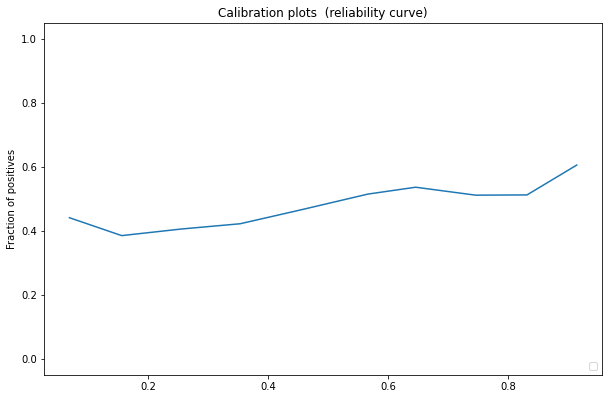

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.7141911839702261


#Fold 4 evaluation

In [ ]:
test_gen = train_generator(test_data)
predictions = ansamble.models[3].predict_generator(test_gen, steps=num_test_items, verbose=1).squeeze()
y_pred = np.array((predictions>0.5), dtype='int32')

    94/107511 [..............................] - ETA: 2:55

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 190s 2ms/step


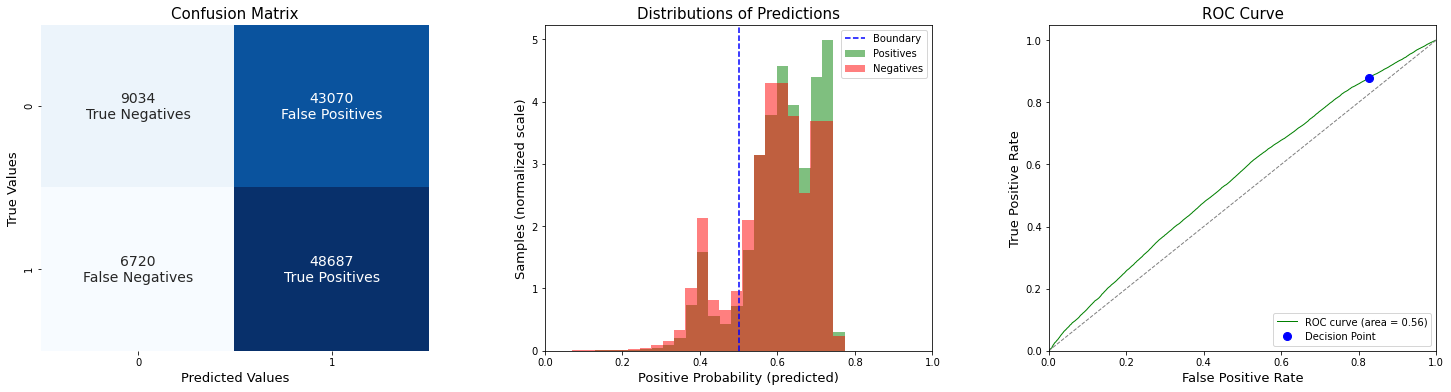

Precision: 0.53 | Recall: 0.88 | F1 Score: 0.66 | 


0.6616699736348562

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,6161,4591,0.43,0.83
1,6109,4642,0.43,0.83
2,5247,5504,0.51,0.99
3,5563,5188,0.48,0.93
4,5029,5722,0.53,1.03
5,5127,5624,0.52,1.01
6,5043,5708,0.53,1.03
7,4769,5982,0.56,1.09
8,4710,6041,0.56,1.09
9,4346,6405,0.60,1.16


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,679,397,0.37,0.72
1,637,438,0.41,0.80
2,619,456,0.42,0.81
3,643,432,0.40,0.78
4,572,503,0.47,0.91
...,...,...,...,...
95,403,672,0.63,1.22
96,381,694,0.65,1.26
97,439,636,0.59,1.14
98,325,750,0.70,1.36


No handles with labels found to put in legend.


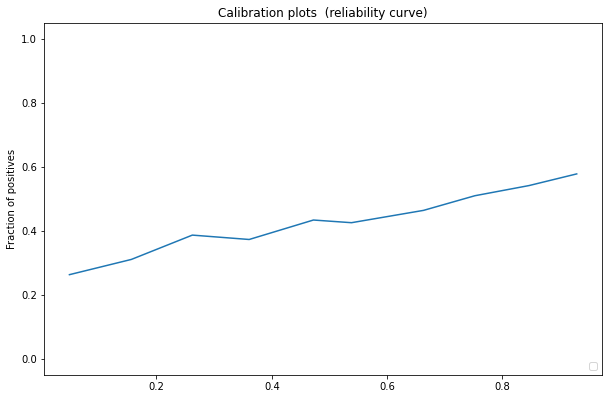

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.7101645300312447


#Fold 5 evaluation

In [ ]:
test_gen = train_generator(test_data)
predictions = ansamble.models[4].predict_generator(test_gen, steps=num_test_items, verbose=1).squeeze()
y_pred = np.array((predictions>0.5), dtype='int32')

    96/107511 [..............................] - ETA: 2:52

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 190s 2ms/step


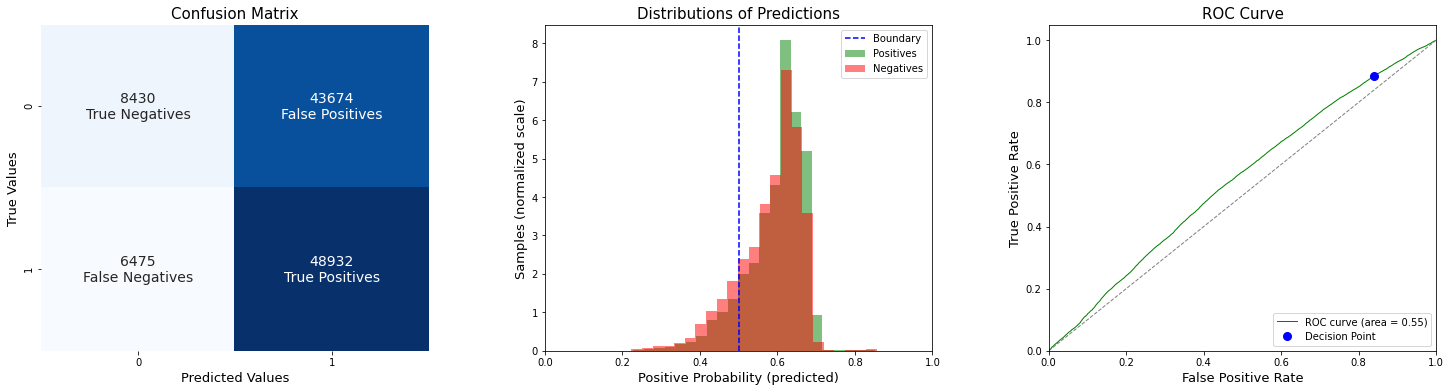

Precision: 0.53 | Recall: 0.88 | F1 Score: 0.66 | 


0.6611851661678366

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,6123,4629,0.43,0.83
1,5824,4927,0.46,0.89
2,5516,5235,0.49,0.95
3,5368,5383,0.50,0.97
4,5338,5413,0.50,0.97
5,4963,5788,0.54,1.05
6,4882,5869,0.55,1.07
7,4761,5990,0.56,1.09
8,4564,6187,0.58,1.13
9,4765,5986,0.56,1.09


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,619,457,0.42,0.81
1,615,460,0.43,0.83
2,675,400,0.37,0.72
3,661,414,0.39,0.76
4,600,475,0.44,0.85
...,...,...,...,...
95,483,592,0.55,1.07
96,530,545,0.51,0.99
97,500,575,0.53,1.03
98,486,589,0.55,1.07


No handles with labels found to put in legend.


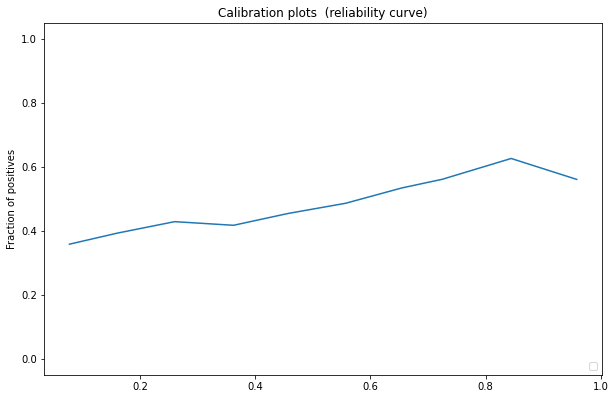

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.7028867929560979


#Evaluate Ansamble

In [ ]:
del ansamble.models[2]

In [ ]:
predictions = ansamble.predict(test_data, train_generator, num_test_items)
y_pred = np.array((predictions>0.58), dtype='int32')

    69/107511 [..............................] - ETA: 2:40

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    84/107511 [..............................] - ETA: 3:15

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    96/107511 [..............................] - ETA: 2:55

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    68/107511 [..............................] - ETA: 2:42

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


107511/107511 [==============================] - 195s 2ms/step


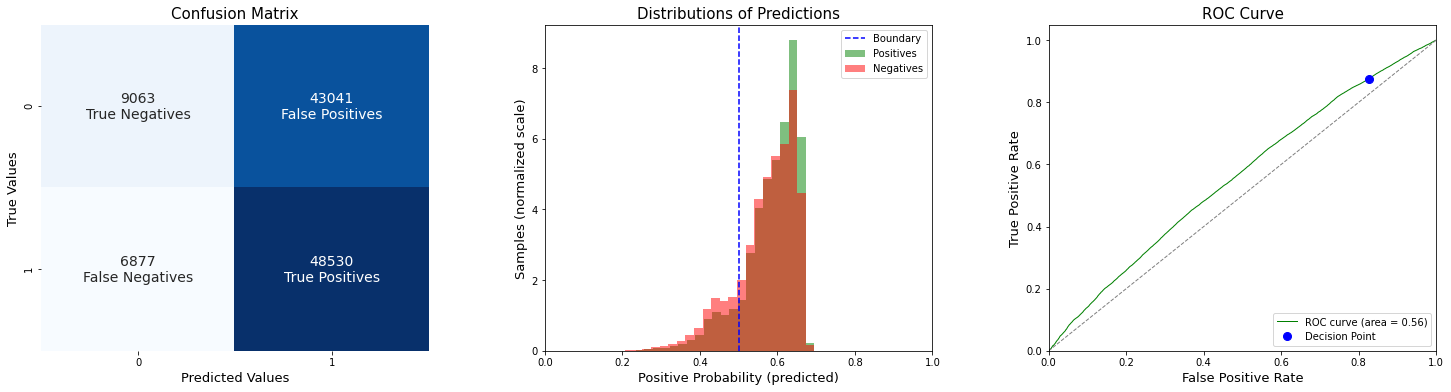

Precision: 0.53 | Recall: 0.88 | F1 Score: 0.66 | 


0.6603709398685517

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,6173,4579,0.43,0.83
1,6070,4681,0.44,0.85
2,5388,5363,0.50,0.97
3,5459,5292,0.49,0.95
4,5065,5686,0.53,1.03
5,5318,5433,0.51,0.99
6,4854,5897,0.55,1.07
7,4867,5884,0.55,1.07
8,4652,6099,0.57,1.11
9,4258,6493,0.60,1.16


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,638,438,0.41,0.80
1,642,433,0.40,0.78
2,618,457,0.43,0.83
3,668,407,0.38,0.74
4,634,441,0.41,0.80
...,...,...,...,...
95,460,615,0.57,1.11
96,353,722,0.67,1.30
97,392,683,0.64,1.24
98,425,650,0.60,1.16


No handles with labels found to put in legend.


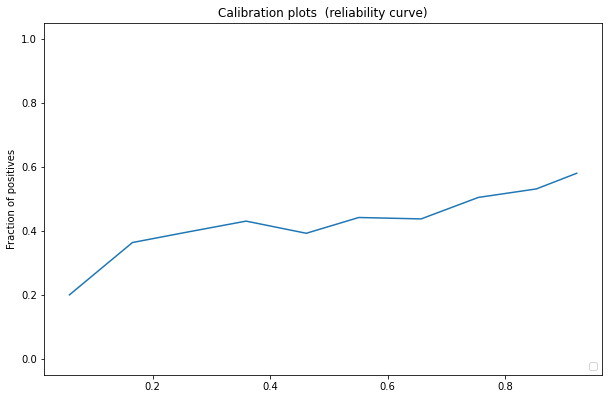

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.6969929513364362


#Evaluate ansamble on the last timestamp

In [ ]:
test_data = filter_by_period(train_features, "2013-01-01", "2013-12-31")
num_test_items = len(test_data['tradingitemid'].unique())
test_data = test_data.set_index('tradingitemid')
y_true = []
test_gen = test_generator_fast(test_data)
for i in range(num_test_items):
    y_true.append(int(next(test_gen)[1][0][0]))

In [ ]:
predictions = ansamble.predict(test_data, test_generator_fast, num_test_items)
y_pred = np.array((predictions>0.58), dtype='int32')

  43/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  43/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  42/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  42/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3405/3405 [==============================] - 8s 2ms/step


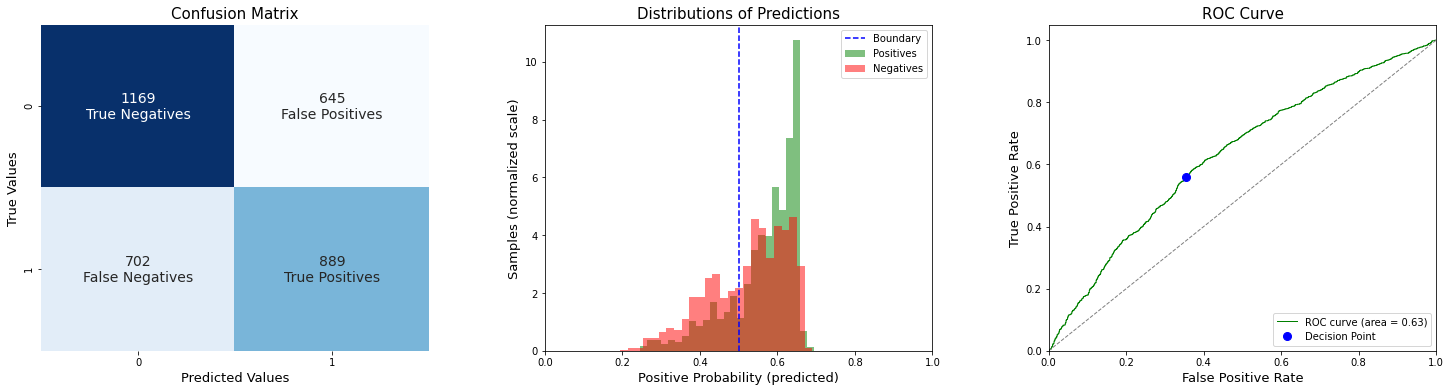

Precision: 0.58 | Recall: 0.56 | F1 Score: 0.57 | 


0.5689599999999999

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,236,105,0.31,0.66
1,231,109,0.32,0.68
2,212,129,0.38,0.81
3,210,130,0.38,0.81
4,195,146,0.43,0.92
5,155,185,0.54,1.16
6,163,177,0.52,1.11
7,153,188,0.55,1.18
8,135,205,0.60,1.28
9,124,217,0.64,1.37


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,23,12,0.34,0.73
1,21,13,0.38,0.81
2,24,10,0.29,0.62
3,24,10,0.29,0.62
4,24,10,0.29,0.62
...,...,...,...,...
95,11,23,0.68,1.46
96,12,22,0.65,1.39
97,10,24,0.71,1.52
98,10,24,0.71,1.52


No handles with labels found to put in legend.


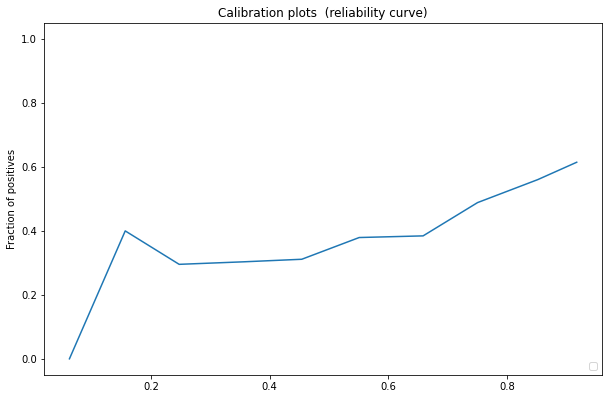

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.6807563280437836


#Train on hold out

In [ ]:
folds_scores = []
for fold_id, fold in enumerate(hold_out_config):
    fold_id = fold_id + 6
    tf.compat.v1.reset_default_graph()
    inputs = keras.Input(shape=(None, 32), dtype="float32")
    x = layers.LSTM(64)(inputs)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", metrics=tf.keras.metrics.AUC(), optimizer='adam')

    train_data = filter_by_period(train_features, fold.train_start_date, fold.train_end_date)
    test_data = filter_by_period(train_features, fold.test_start_date, fold.test_end_date)

    num_test_items = len(test_data['tradingitemid'].unique())
    train_data = train_data.set_index(['tradingitemid'])
    test_data = test_data.set_index(['tradingitemid'])

    scores_log = []
    partition_size = 1000
    best_val_auc = -np.inf
    num_partitions = int(train_data.shape[0] / partition_size)

    print(f'\n Fold {fold_id} training started...')
    for epoch in range(1):
        for i in tqdm(range(num_partitions), total=num_partitions):
            train_data_partition = train_data.iloc[i * partition_size : (i + 1) * partition_size]
            train_gen = train_generator(train_data_partition)
            test_gen = test_generator_fast(test_data)
            scores = model.fit(train_gen, epochs=1, steps_per_epoch=partition_size, validation_data=test_gen, validation_steps=num_test_items, verbose=1)
            val_auc = scores.history['val_auc'][0]
            scores_log.append(val_auc)
            if val_auc > best_val_auc:
                model.save_weights(f'/content/drive/MyDrive/Work/Meson/lstm_best_loss_fold_{fold_id}.weights')
                best_val_auc = val_auc
                print(f'Best model saved! Scores: {scores.history}')
    folds_scores.append(scores_log)

#Evaluate final ansemble

In [ ]:
train_models = ansamble.models.copy()

In [ ]:
ansamble = Ansemple()
ansamble.load_models(base_model_path='/content/drive/MyDrive/Work/Meson/lstm_best_loss_fold_', num_folds=3, num_skip=6)

In [ ]:
for model in train_models:
    ansamble.models.append(model)

In [ ]:
test_data = filter_by_period(train_features, "2013-01-01", "2013-12-31")
num_test_items = len(test_data['tradingitemid'].unique())
test_data = test_data.set_index('tradingitemid')
y_true = []
test_gen = test_generator_fast(test_data)
for i in range(num_test_items):
    y_true.append(int(next(test_gen)[1][0][0]))

In [ ]:
predictions = ansamble.predict(test_data, test_generator_fast, num_test_items)
y_pred = np.array((predictions>0.58), dtype='int32')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3405/3405 [==============================] - 9s 2ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3405/3405 [==============================] - 9s 3ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  43/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  42/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  42/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  41/3405 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3405/3405 [==============================] - 9s 3ms/step


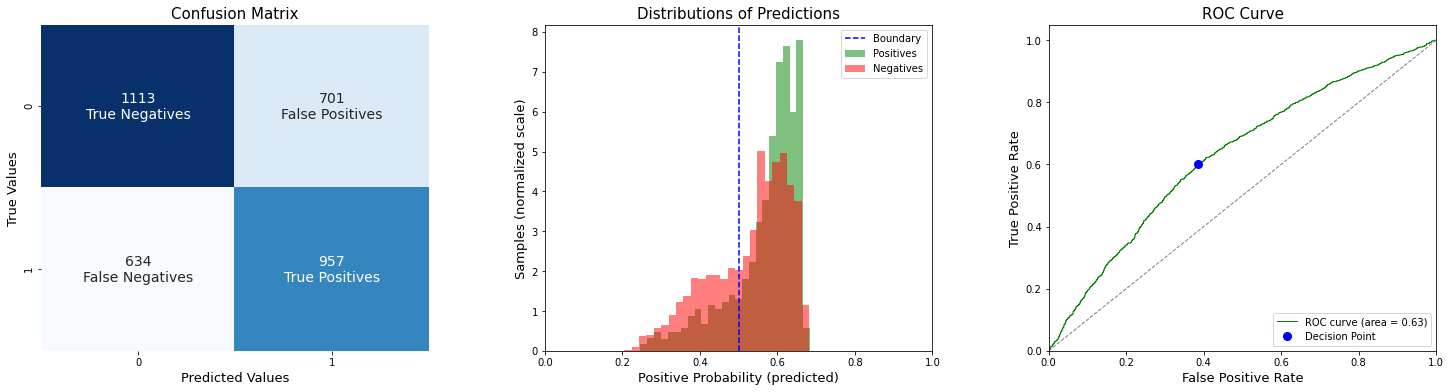

Precision: 0.58 | Recall: 0.6 | F1 Score: 0.59 | 


0.5891043397968606

In [ ]:
evaluate_classifier(y_true, y_pred, predictions, labels=['Positives','Negatives'])

In [ ]:
lift(y_true, predictions, 10)

Target,Negatives,Positives,positive_rate,lift
0,235,106,0.31,0.66
1,235,105,0.31,0.66
2,214,127,0.37,0.79
3,201,139,0.41,0.88
4,202,139,0.41,0.88
5,167,173,0.51,1.09
6,145,195,0.57,1.22
7,155,186,0.55,1.18
8,134,206,0.61,1.31
9,126,215,0.63,1.35


In [ ]:
lift(y_true, predictions, 100)

Target,Negatives,Positives,positive_rate,lift
0,24,11,0.31,0.66
1,22,12,0.35,0.75
2,22,12,0.35,0.75
3,25,9,0.26,0.56
4,24,10,0.29,0.62
...,...,...,...,...
95,11,23,0.68,1.46
96,10,24,0.71,1.52
97,17,17,0.50,1.07
98,13,21,0.62,1.33


No handles with labels found to put in legend.


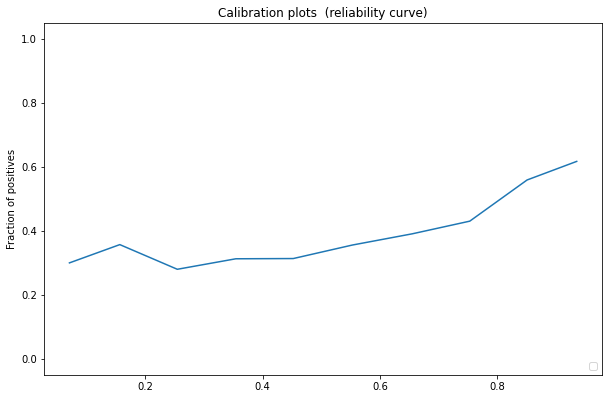

In [ ]:
plot_calibration_curve(y_true, predictions)

In [ ]:
print(f'Log Loss: {log_loss(y_true, predictions)}')

Log Loss: 0.6820063561463671


#Run final predictions

In [ ]:
import pandas as pd

In [ ]:
test_data = pd.read_pickle('data/test_features.pkl').reset_index()
test_data['g__12m_binary'] = 0
test_data = test_data.fillna(train_features.mean())
date = test_data['date']
data = test_data[columns]
data = scaler.transform(data)
test_data[columns] = data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
num_test_items = len(test_data)
test_data = test_data.set_index('tradingitemid')

In [ ]:
test_data['g__12m_binary'] = ansamble.predict(test_data, train_generator, num_test_items)

    32/627908 [..............................] - ETA: 17:22  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    33/627908 [..............................] - ETA: 16:55  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    33/627908 [..............................] - ETA: 16:27  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    32/627908 [..............................] - ETA: 16:58  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    32/627908 [..............................] - ETA: 16:54  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    32/627908 [..............................] - ETA: 17:18  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    32/627908 [..............................] - ETA: 16:58  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


627908/627908 [==============================] - 2466s 4ms/step


In [ ]:
test_data['date'] = date

In [ ]:
test_data = test_data[['date', 'tradingitemid', 'g__12m_binary']]

In [ ]:
test_data = test_data.set_index(['date', 'tradingitemid'])

In [ ]:
with open('/content/drive/MyDrive/Work/Meson/predictions.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [ ]:
with open('/content/drive/MyDrive/Work/Meson/predictions.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
test_data

g__12m_binary
date       tradingitemid               
2016-01-01 2585893             0.588000
           2585895             0.596317
           2586016             0.627458
           2586068             0.628570
           2586084             0.629550
...                                 ...
2019-09-20 633841867           0.313196
           634751265           0.313196
           635766194           0.313196
           636344928           0.313196
           637117468           0.313196

[627908 rows x 1 columns]